In [7]:
###Import the usual libraries
import numpy as np
import math

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 24}) #make plots more readable

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column, vstack, hstack, MaskedColumn
from astropy import units as u
from astropy.coordinates import SkyCoord

#import scipy.optimize as opt
from scipy.stats import kurtosis, skew, iqr

import csv

filepath1 = '/Users/joshpovick/Desktop/Research/fits/final_dupont_oct09.fits'
filepath2 = '/Users/joshpovick/Desktop/Research/fits/dupont7.fits'
filepath3 = '/Users/joshpovick/Desktop/Research/fits/bstars.fits' #original icr stars fits
filepath4 = '/Users/joshpovick/Desktop/Research/fits/gaia6as.fits' #icr stars xmatched with bstars.fits

In [2]:
###Code to Convert to MS coordinates
from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import rotation_matrix, matrix_product, matrix_transpose
import astropy.coordinates as coord
import astropy.units as u
from astropy.coordinates import SkyCoord

class MagellanicStream(coord.BaseCoordinateFrame):
    """
    A Heliocentric spherical coordinate system defined by the Magellanic Stream
    Parameters
    ----------
    representation : `BaseRepresentation` or None
        A representation object or None to have no data (or use the other keywords)
    MSLongitude : `Angle`, optional, must be keyword
        The longitude-like angle corresponding to the Magellanic Stream.
    MSLatitude : `Angle`, optional, must be keyword
        The latitude-like angle corresponding to the Magellanic Stream.
    distance : `Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.
    pm_Lambda_cosBeta : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion along the Stream in ``Lambda`` (including the
        ``cos(Beta)`` factor) for this object (``pm_Beta`` must also be given).
    pm_Beta : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in Declination for this object (``pm_ra_cosdec`` must
        also be given).
    radial_velocity : :class:`~astropy.units.Quantity`, optional, must be keyword
        The radial velocity of this object.
    """
    default_representation = coord.SphericalRepresentation
    #default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'MSLongitude'),
            coord.RepresentationMapping('lat', 'MSLatitude'),
            coord.RepresentationMapping('distance', 'distance')]#,
        #coord.SphericalCosLatDifferential: [
        #    coord.RepresentationMapping('d_lon_coslat', 'pm_lon_coslat'),
        #    coord.RepresentationMapping('d_lat', 'pm_lat'),
        #    coord.RepresentationMapping('d_distance', 'radial_velocity')],
        #coord.SphericalDifferential: [
        #    coord.RepresentationMapping('d_lon', 'pm_lon'),
        #    coord.RepresentationMapping('d_lat', 'pm_lat'),
        #   coord.RepresentationMapping('d_distance', 'radial_velocity')]
    }

    frame_specific_representation_info[coord.UnitSphericalRepresentation] = \
        frame_specific_representation_info[coord.SphericalRepresentation]
    #frame_specific_representation_info[coord.UnitSphericalCosLatDifferential] = \
    #    frame_specific_representation_info[coord.SphericalCosLatDifferential]
    #frame_specific_representation_info[coord.UnitSphericalDifferential] = \
    #    frame_specific_representation_info[coord.SphericalDifferential]


MS_PHI = (180 + 8.5 + 90) * u.degree # Euler angles (from Nidever 2010)
MS_THETA = (90 + 7.5) * u.degree
MS_PSI = -32.724214217871349 * u.degree  # anode parameter from gal2mag.pro

D = rotation_matrix(MS_PHI, "z")
C = rotation_matrix(MS_THETA, "x")
B = rotation_matrix(MS_PSI, "z")
A = np.diag([1., 1., 1.])
MS_MATRIX = matrix_product(A, B, C, D)

@frame_transform_graph.transform(coord.StaticMatrixTransform, coord.Galactic, MagellanicStream)
def galactic_to_MS():
    """ Compute the transformation matrix from Galactic spherical to
        Magellanic Stream coordinates.
    """
    return MS_MATRIX

@frame_transform_graph.transform(coord.StaticMatrixTransform, MagellanicStream, coord.Galactic)
def MS_to_galactic():
    """ Compute the transformation matrix from Magellanic Stream coordinates to
        spherical Galactic.
    """
    return matrix_transpose(MS_MATRIX)

###Actual coordinate transform from previous cell
#c_icrs = SkyCoord(ra=tmp.ra.data*u.degree, dec=tmp.dec.data*u.degree)
#c_ms = c_icrs.transform_to(MagellanicStream)
#ms_lg,ms_bg = c_ms.MSLongitude.degree, c_ms.MSLatitude.degree

In [ ]:
###Import Data from fits files
dupont = fits.getdata(filepath1,1)
dupont7 = fits.getdata(filepath2,1)
icr = fits.getdata(filepath3,1)
gaia6 = fits.getdata(filepath4,1)

#Create a table to xmatch with gaia
#tdupont = Table(dupont)
#astropy.io.ascii.write(tdupont,'dupont.txt')

#Create table of the xmatch data from dupont and rename columns
tdupontgaia7 = Table(dupont7)

tdupontgaia7['col1'].name = 'NAME'
tdupontgaia7['col2'].name = 'FILE'
tdupontgaia7['col3'].name = 'MEDCOUNT'
tdupontgaia7['col4'].name = 'SNR'
tdupontgaia7['col5'].name = 'RA'
tdupontgaia7['col6'].name = 'DEC'
tdupontgaia7['col7'].name = 'GLON'
tdupontgaia7['col8'].name = 'GLAT'    
tdupontgaia7['col9'].name = 'MLON'
tdupontgaia7['col10'].name = 'MLAT'
tdupontgaia7['col11'].name = 'VHELIO'
tdupontgaia7['col12'].name = 'VLSR'
tdupontgaia7['col13'].name = 'VGSR'
tdupontgaia7['col14'].name = 'STDEV'
tdupontgaia7['col15'].name = 'VERR'
tdupontgaia7['col16'].name = 'V' 
tdupontgaia7['col17'].name = 'BV'
tdupontgaia7['gaia_rad_xmatch'] = 7.0 #add in column for xmatch radius in units of as

#Create table of the xmatch data from icr and rename columns
ticrgaia6 = Table(gaia6)

ticrgaia6['col1'].name = 'NAME'
ticrgaia6['col2'].name = 'RA'
ticrgaia6['col3'].name = 'DEC'
ticrgaia6['col4'].name = 'GLON'
ticrgaia6['col5'].name = 'GLAT'
ticrgaia6['col6'].name = 'MLON'
ticrgaia6['col7'].name = 'MLAT'
ticrgaia6['col8'].name = 'V'
ticrgaia6['col9'].name = 'BV'
ticrgaia6['col10'].name = 'EBV'
ticrgaia6['col11'].name = 'VHELIO_SMARTS'
ticrgaia6['col12'].name = 'VERR_SMARTS'
ticrgaia6['col13'].name = 'VHELIO_MIKE'
ticrgaia6['col14'].name = 'VERR_MIKE'
ticrgaia6['col15'].name = 'VHELIO'
ticrgaia6['col16'].name = 'VERR'
ticrgaia6['col17'].name = 'VELTYPE'
ticrgaia6['col18'].name = 'VLSR'
ticrgaia6['col19'].name = 'VGSR'
ticrgaia6['col20'].name = 'LMCVLOS'
ticrgaia6['col21'].name = 'TEFF'
ticrgaia6['col22'].name = 'TEFFERR'
ticrgaia6['col23'].name = 'LOGG'
ticrgaia6['col24'].name = 'LOGGERR'
ticrgaia6['col25'].name = 'METAL'
ticrgaia6['col26'].name = 'METALERR'
ticrgaia6['col27'].name = 'VSINI'
ticrgaia6['col28'].name = 'VSINIERR'
ticrgaia6['gaia_rad_xmatch'] = 6.0 #add in column for xmatch radius in units of as

In [ ]:
###Create a master table (includes duplicate values from Gaia)

'''Need to uncomment master.write if need to make the master fits file (if it does not already exist in the dir)'''

master=vstack([tdupontgaia7,ticrgaia6])
#master.write('master.fits',format='fits')
master.show_in_browser(jsviewer=True)
#tdupontgaia7.show_in_browser(jsviewer=True)
#ticrgaia6.show_in_browser(jsviewer=True)

In [ ]:
###Find and rid the data of duplicates 

#Find duplicates in the xmatched data for dupont xmatch
nom = np.append(dupont['NAME'],icr['NAME'])
idx = []
for i in range(len(dupont['NAME'])+len(icr['NAME'])):
    a = [j for j,x in enumerate(master['NAME']) if x == nom[i]]
    idx.append(a)

b = [k for k, y in enumerate(idx) if len(idx[k])>1]

print(master['dist'][6],'1st set 6')
print(master['dist'][7],'1st set 7')
print(master['dist'][10],'2nd set 10')
print(master['dist'][11],'2nd set 11')
print(master['dist'][19],'3rd set 19')
print(master['dist'][72],'3rd set 72')
print(master['dist'][25],'4th set 25')
print(master['dist'][110],'4th set 110')
print(master['dist'][30],'5th set 30')
print(master['dist'][31],'5th set 31')
print(master['dist'][34],'6th set 34')
print(master['dist'][112],'6th set 112')
print(master['dist'][38],'7th set 38')
print(master['dist'][39],'7th set 39')
print(master['dist'][41],'8th set 41')
print(master['dist'][97],'8th set 97')
print(master['dist'][61],'9th set 61')
print(master['dist'][62],'9th set 62')
print(master['dist'][63],'9th set 63')
print(master['dist'][78],'10th set 78')
print(master['dist'][79],'10th set 79')
print(master['dist'][91],'11th set 91')
print(master['dist'][92],'11th set 92')
print(master['dist'][93],'11th set 93')
print(master['dist'][94],'11th set 94')
print(master['dist'][101],'12th set 101')
print(master['dist'][102],'12th set 102')
print(master['dist'][103],'13th set 103')
print(master['dist'][104],'13th set 104')
print(master['dist'][107],'14th set 107')
print(master['dist'][108],'14th set 108')

keepidx = np.arange(0,113,1)
keepidx = np.delete(keepidx,[6,11,19,25,30,39,41,61,62,79,91,93,94,102,103,107,112])

In [ ]:
#Pick out all relavent data from master.fits

gaiara = []
gaiadec = []
pmra = []
pmdec = []
vlsr = []
vhelio = []
BPRP = []
BPG = []
GRP = []

for i in keepidx:
    gaiara.append(master['ra'][i]) 
    gaiadec.append(master['dec'][i])
    pmra.append(master['pmra'][i])
    pmdec.append(master['pmdec'][i])
    vlsr.append(master['VLSR'][i])
    vhelio.append(master['VHELIO'][i])
    BPRP.append(master['bp_rp'][i])
    BPG.append(master['bp_g'][i])
    GRP.append(master['g_rp'][i])
    
#Transform gaia ra and dec to L and B
c_icrs = SkyCoord(ra=gaiara*u.degree, dec=gaiadec*u.degree)
c_ms = c_icrs.transform_to(MagellanicStream)
ms_lg,ms_bg = c_ms.MSLongitude.degree, c_ms.MSLatitude.degree

In [ ]:
###Data Plots

#pmra, L, vlsr
plt.figure(figsize = [25,15])
plt.scatter(ms_lg-360,pmra,c=vlsr,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$L_{MS}$')
plt.ylabel('pmra ($mas$ $yr^{-1}$)')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $V_{LSR}$ $(km$ $s^{-1})$')
plt.savefig('pmra_L_vlsr2.pdf', bbox_inches='tight')
plt.show()

#pmra, B, vlsr
plt.figure(figsize = [25,15])
plt.scatter(ms_bg,pmra,c=vlsr,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$B_{MS}$')
plt.ylabel('pmra $(mas$ $yr^{-1}$)')
plt.colorbar()
plt.title('Color as $V_{LSR}$ $(km$ $s^{-1})$')
plt.savefig('pmra_B_vlsr2.pdf', bbox_inches='tight')
plt.show()

#pmdec, L, vlsr
plt.figure(figsize = [25,15])
plt.scatter(ms_lg-360,pmdec,c=vlsr,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$L_{MS}$')
plt.ylabel('pmdec $(mas$ $yr^{-1})$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $V_{LSR}$ $(km$ $s^{-1})$')
plt.savefig('pmdec_L_vlsr2.pdf', bbox_inches='tight')
plt.show()

#pmdec, B, vlsr
plt.figure(figsize = [25,15])
plt.scatter(ms_bg,pmdec,c=vlsr,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$B_{MS}$')
plt.ylabel('pmdec $(mas$ $yr^{-1})$')
plt.colorbar()
plt.title('Color as $V_{LSR}$ $(km$ $s^{-1})$')
plt.savefig('pmdec_B_vlsr2.pdf', bbox_inches='tight')
plt.show()

#pmra, L, BP-RP
plt.figure(figsize = [25,15])
plt.scatter(ms_lg-360,pmra,c=BPRP,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$L_{MS}$')
plt.ylabel('pmra $(mas$ $yr^{-1})$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $BP-RP$')
plt.savefig('pmra_L_bprp2.pdf', bbox_inches='tight')
plt.show()

#pmra, B, BP-RP
plt.figure(figsize = [25,15])
plt.scatter(ms_bg,pmra,c=BPRP,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$B_{MS}$')
plt.ylabel('pmra $(mas$ $yr^{-1})$')
plt.colorbar()
plt.title('Color as $BP-RP$')
plt.savefig('pmra_B_bprp2.pdf', bbox_inches='tight')
plt.show()

#pmdec, L, BP-RP
plt.figure(figsize = [25,15])
plt.scatter(ms_lg-360,pmdec,c=BPRP,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$L_{MS}$')
plt.ylabel('pmdec $(mas$ $yr^{-1})$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $BP-RP$')
plt.savefig('pmdec_L_bprp2.pdf', bbox_inches='tight')
plt.show()

#pmdec, B, BP-RP
plt.figure(figsize = [25,15])
plt.scatter(ms_bg,pmdec,c=BPRP,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$B_{MS}$')
plt.ylabel('pmdec $(mas$ $yr^{-1})$')
plt.colorbar()
plt.title('Color as $BP-RP$')
plt.savefig('pmdec_B_bprp2.pdf', bbox_inches='tight')
plt.show()

#pmra, L, BP-G
plt.figure(figsize = [25,15])
plt.scatter(ms_lg-360,pmra,c=BPG,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$L_{MS}$')
plt.ylabel('pmra $(mas$ $yr^{-1})$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $BP-G$')
plt.savefig('pmra_L_bpg2.pdf', bbox_inches='tight')
plt.show()

#pmra, B, BP-G
plt.figure(figsize = [25,15])
plt.scatter(ms_bg,pmra,c=BPG,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$B_{MS}$')
plt.ylabel('pmra $(mas$ $yr^{-1})$')
plt.colorbar()
plt.title('Color as $BP-G$')
plt.savefig('pmra_B_bpg2.pdf', bbox_inches='tight')
plt.show()

#pmdec, L, BP-G
plt.figure(figsize = [25,15])
plt.scatter(ms_lg-360,pmdec,c=BPG,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$L_{MS}$')
plt.ylabel('pmdec $(mas$ $yr^{-1})$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $BP-G$')
plt.savefig('pmdec_L_bpg2.pdf', bbox_inches='tight')
plt.show()

#pmdec, B, BP-G
plt.figure(figsize = [25,15])
plt.scatter(ms_bg,pmdec,c=BPG,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$B_{MS}$')
plt.ylabel('pmdec $(mas$ $yr^{-1})$')
plt.colorbar()
plt.title('Color as $BP-G$')
plt.savefig('pmdec_B_bpg2.pdf', bbox_inches='tight')
plt.show()

#pmra, L, G-RP
plt.figure(figsize = [25,15])
plt.scatter(ms_lg-360,pmra,c=GRP,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$L_{MS}$')
plt.ylabel('pmra $(mas$ $yr^{-1})$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $G-RP$')
plt.savefig('pmra_L_grp2.pdf', bbox_inches='tight')
plt.show()

#pmra, B, G-RP
plt.figure(figsize = [25,15])
plt.scatter(ms_bg,pmra,c=GRP,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$B_{MS}$')
plt.ylabel('pmra $(mas$ $yr^{-1})$')
plt.colorbar()
plt.title('Color as $G-RP$')
plt.savefig('pmra_B_grp2.pdf', bbox_inches='tight')
plt.show()

#pmdec, L, G-RP
plt.figure(figsize = [25,15])
plt.scatter(ms_lg-360,pmdec,c=GRP,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$L_{MS}$')
plt.ylabel('pmdec $(mas$ $yr^{-1})$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $G-RP$')
plt.savefig('pmdec_L_grp2.pdf', bbox_inches='tight')
plt.show()

#pmdec, B, G-RP
plt.figure(figsize = [25,15])
plt.scatter(ms_bg,pmdec,c=GRP,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$B_{MS}$')
plt.ylabel('pmdec $(mas$ $yr^{-1})$')
plt.colorbar()
plt.title('Color as $G-RP$')
plt.savefig('pmdec_B_grp2.pdf', bbox_inches='tight')
plt.show()

#positon, vlsr
plt.figure(figsize=[25,15])
plt.scatter(ms_lg-360,ms_bg,c=vlsr,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$L_{MS}$')
plt.ylabel('$B_{MS}$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $V_{LSR}$ $(km$ $s^{-1})$')
plt.savefig('position_vlsr2.pdf', bbox_inches='tight')
plt.show()

#position, pmra
plt.figure(figsize=[25,15])
plt.scatter(ms_lg-360,ms_bg,c=pmra,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$L_{MS}$')
plt.ylabel('$B_{MS}$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $pmra$ $(mas$ $yr^{-1})$')
plt.savefig('positon_pmra2.pdf', bbox_inches='tight')
plt.show()

#position, pmdec
plt.figure(figsize=[25,15])
plt.scatter(ms_lg-360,ms_bg,c=pmdec,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$L_{MS}$')
plt.ylabel('$B_{MS}$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $pmdec$ $(mas$ $yr^{-1})$')
plt.savefig('position_pmdec2.pdf', bbox_inches='tight')
plt.show()

#position, BP-RP
plt.figure(figsize=[25,15])
plt.scatter(ms_lg-360,ms_bg,c=BPRP,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$L_{MS}$')
plt.ylabel('$B_{MS}$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $BP-RP$')
plt.savefig('position_bprp2.pdf', bbox_inches='tight')
plt.show()

#position, BP-G
plt.figure(figsize=[25,15])
plt.scatter(ms_lg-360,ms_bg,c=BPG,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$L_{MS}$')
plt.ylabel('$B_{MS}$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $BP-G$')
plt.savefig('position_grp2.pdf', bbox_inches='tight')
plt.show()

#position, G-RP
plt.figure(figsize=[25,15])
plt.scatter(ms_lg-360,ms_bg,c=GRP,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$L_{MS}$')
plt.ylabel('$B_{MS}$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $G-RP$')
plt.savefig('position_grp2.pdf', bbox_inches='tight')
plt.show()

#pmdec, pmra, vlsr
plt.figure(figsize=[25,15])
plt.scatter(pmra,pmdec,c=vlsr,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('pmra $(mas$ $yr^{-1}$)')
plt.ylabel('pmdec $(mas$ $yr^{-1}$)')
plt.colorbar()
plt.title('Color as $V_{LSR}$ $(km$ $s^{-1})$')
plt.savefig('pmdec_pmra_vlsr2.pdf',bbox_inches='tight')
plt.show()

#vhelio, L, pmra
plt.figure(figsize=[25,15])
plt.scatter(ms_lg-360,vhelio,c=pmra,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$L_{MS}$')
plt.ylabel('$V_{helio}$')
plt.colorbar()
plt.title('Color as $pmra$ $(mas$ $yr^{-1})$')
plt.savefig('vhelio_L_pmra2.pdf',bbox_inches='tight')
plt.show()

#vhelio, L, pmdec
plt.figure(figsize=[25,15])
plt.scatter(ms_lg-360,vhelio,c=pmdec,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$L_{MS}$')
plt.ylabel('$V_{helio}$')
plt.colorbar()
plt.title('Color as $pmdec$ $(mas$ $yr^{-1})$')
plt.savefig('vhelio_L_pmdec2.pdf',bbox_inches='tight')
plt.show()

In [ ]:
###Coordinate Conversion for LMC and SMC Periphery

print(SkyCoord(l = 290*u.degree, b = -35*u.degree, frame = 'galactic').icrs) #LMC
print(SkyCoord(l = 299*u.degree, b = -42*u.degree, frame = 'galactic').icrs) #SMC

In [4]:
###Import Periphery Data
filepath5 = '/Users/joshpovick/Desktop/Research/fits/gaialmcper_1degdia.fits' #ra: 64.24290029 dec:-76.4305723
filepath6 = '/Users/joshpovick/Desktop/Research/fits/gaiasmcper_1degdia.fits' #ra: 24.05542837 dec:-74.78460052

lmcper = fits.getdata(filepath5,1)
smcper = fits.getdata(filepath6,1)

lpmra = lmcper['pmra']
lpmdec = lmcper['pmdec']
spmra = smcper['pmra']
spmdec = smcper['pmdec']

lparallax = lmcper['parallax']
sparallax = smcper['parallax']


In [ ]:
###Plots for proper motion in periphery 

#lpmdec, lpmra
plt.figure(figsize=[25,15])
plt.scatter(lpmra,lpmdec,label='raw data')
plt.scatter(np.nanmean(lpmra),np.nanmean(lpmdec),label='avg $\mu$ = (4.97,4.71)')
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('$\mu_{\delta}$ $(mas$ $yr^{-1}$)')
plt.title('Raw Gaia Proper Motion Plot LMC Periphery')
plt.savefig('rawlmcpm.pdf',bbox_inches='tight')
plt.legend()
plt.show()

#spmdec, spmra
plt.figure(figsize=[25,15])
plt.scatter(spmra,spmdec,label='raw data')
plt.scatter(np.nanmean(spmra),np.nanmean(spmdec),label='avg $\mu$ = (4.06,-0.798)')
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('$\mu_{\delta}$ $(mas$ $yr^{-1}$)')
plt.title('Raw Gaia Proper Motion Plot SMC Periphery')
plt.savefig('rawsmcpm.pdf',bbox_inches='tight')
plt.legend()
plt.show()

In [ ]:
cleanlpmra = [x for x in lpmra if str(x) != 'nan'] #most useful code ever!!!!!!!!!!!!!!!!!!!!!

avglpmra = np.mean(cleanlpmra)
siglpmra = np.std(cleanlpmra)

zlra = np.linspace(-134,142,10000)

def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

plt.figure(figsize=[25,15])
plt.hist(cleanlpmra,range(-134,142),density=True)
plt.plot(zlra,gaussian(zlra,avglpmra,siglpmra))
plt.title('LMC pmra with Gaussian Overplot')
plt.savefig('rawlmcpmra.pdf',bbox_inches='tight')
plt.show()

print('mean = '+ str(np.mean(cleanlpmra)))
print('std = '+ str(np.std(cleanlpmra)))
print('skew = '+ str(skew(cleanlpmra)))
print('kurtosis = '+ str(kurtosis(cleanlpmra)))
print('median = '+ str(np.median(cleanlpmra)))
print('IQR = '+ str(iqr(cleanlpmra)))

In [ ]:
cleanlpmdec = [x for x in lpmdec if str(x) != 'nan']

avglpmdec = np.mean(cleanlpmdec)
siglpmdec = np.std(cleanlpmdec)

zldec = np.linspace(-95,197,10000)

def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

plt.figure(figsize=[25,15])
plt.hist(cleanlpmdec,range(-95,197),density=True)
plt.plot(zldec,gaussian(zldec,avglpmdec,siglpmdec))
plt.title('LMC pmdec with Gaussian Overplot')
plt.xlabel('$\mu_{\delta}$ $(mas$ $yr^{-1}$)')
plt.ylabel('Density')
plt.savefig('rawlmcpmdec.pdf',bbox_inches='tight')
plt.show()

print('mean = '+ str(np.mean(cleanlpmdec)))
print('std = '+ str(np.std(cleanlpmdec)))
print('skew = '+ str(skew(cleanlpmdec)))
print('kurt = '+ str(kurtosis(cleanlpmdec)))
print('median = '+ str(np.median(cleanlpmdec)))
print('IQR = '+ str(iqr(cleanlpmdec)))

In [ ]:
cleanspmra = [x for x in spmra if str(x) != 'nan']

avgspmra = np.mean(cleanspmra)
sigspmra = np.std(cleanspmra)

zsra = np.linspace(-65,275,10000)

def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

plt.figure(figsize=[25,15])
plt.hist(cleanspmra,range(-65,275), density=True)
plt.plot(zsra,gaussian(zsra,avgspmra,sigspmra))
plt.title('SMC pmra with Gaussian Overplot')
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('Density')
plt.savefig('rawsmcpmra.pdf',bbox_inches='tight')
plt.show()

print('mean = '+ str(np.mean(cleanspmra)))
print('std = '+ str(np.std(cleanspmra)))
print('skew = '+ str(skew(cleanspmra)))
print('kurt = '+ str(kurtosis(cleanspmra)))
print('median = '+ str(np.median(cleanspmra)))
print('IQR = '+ str(iqr(cleanspmra)))

In [ ]:
cleanspmdec = [x for x in spmdec if str(x) != 'nan']

avgspmdec = np.mean(cleanspmdec)
sigspmdec = np.std(cleanspmdec)

zsdec = np.linspace(-182,76,10000)

def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

plt.figure(figsize=[25,15])
plt.hist(cleanspmdec,range(-182,76), density=True)
plt.plot(zsdec,gaussian(zsdec,avgspmdec,sigspmdec))
plt.title('SMC pmdec with Gaussian Overplot')
plt.xlabel('$\mu_{\delta}$ $(mas$ $yr^{-1}$)')
plt.ylabel('Density')
plt.savefig('rawsmcpmdec.pdf',bbox_inches='tight')
plt.show()

print('mean = '+ str(np.mean(cleanspmdec)))
print('std = '+ str(np.std(cleanspmdec)))
print('skew = '+ str(skew(cleanspmdec)))
print('kurt = '+ str(kurtosis(cleanspmdec)))
print('median = '+ str(np.median(cleanspmdec)))
print('IQR = '+ str(iqr(cleanspmdec)))

In [3]:
###Read in Simulated Milky Way Data
bes = astropy.io.ascii.read('/Users/joshpovick/Desktop/Research/MS_young/besancon.dat')
mpmra = bes['mux']*10.0
mpmdec = bes['muy']*10.0
tbes = Table(bes)
tbes.show_in_browser(jsviewer=True)

In [ ]:
###Milky Way Simulated Data Plots

#mpmdec, mpmra
plt.figure(figsize=[25,15])
plt.scatter(mpmra,mpmdec,label='simulated MW data')
plt.scatter(np.nanmean(mpmra),np.nanmean(mpmdec),label='avg $\mu$ = (7.04,3.40)')
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('$\mu_{\delta}$ $(mas$ $yr^{-1}$)')
plt.title('Simulated Milky Way Data in ICR')
plt.savefig('simmwpm.pdf',bbox_inches='tight')
plt.legend()
plt.savefig('simmwpm.pdf',bbox_inches='tight')
plt.show()

#MW pmra + Statistics
cleanmpmra = [x for x in mpmra if str(x) != 'nan']

avgmpmra = np.mean(cleanmpmra)
sigmpmra = np.std(cleanmpmra)

zmra = np.linspace(-55,130,10000)

def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

plt.figure(figsize=[25,15])
plt.hist(cleanmpmra, density=True)
plt.plot(zmra,gaussian(zmra,avgmpmra,sigmpmra))
plt.title('MW pmra with Gaussian Overplot')
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('Desnity')
plt.savefig('simmwpmra.pdf',bbox_inches='tight')
plt.show()

print('mean = '+ str(np.mean(cleanmpmra)))
print('std = '+ str(np.std(cleanmpmra)))
print('skew = '+ str(skew(cleanmpmra)))
print('kurt = '+ str(kurtosis(cleanmpmra)))
print('median = '+ str(np.median(cleanmpmra)))
print('IQR = '+ str(iqr(cleanmpmra)))

#MW pmdec + Statistics
cleanmpmdec = [x for x in mpmdec if str(x) != 'nan']

avgmpmdec = np.mean(cleanmpmdec)
sigmpmdec = np.std(cleanmpmdec)

zmdec = np.linspace(-325,100,10000)

def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

fig = plt.figure(figsize=[25,15])
plt.hist(cleanmpmdec, density=True)
plt.plot(zmdec,gaussian(zmdec,avgmpmdec,sigmpmdec))
plt.title('MW pmdec with Gaussian Overplot')
plt.xlabel('$\mu_{\delta}$ $(mas$ $yr^{-1}$)')
plt.ylabel('Desnity')
plt.savefig('simmwpmdec.pdf',bbox_inches='tight')
plt.show()

print('mean = '+ str(np.mean(cleanmpmdec)))
print('std = '+ str(np.std(cleanmpmdec)))
print('skew = '+ str(skew(cleanmpmdec)))
print('kurt = '+ str(kurtosis(cleanmpmdec)))
print('median = '+ str(np.median(cleanmpmdec)))
print('IQR = '+ str(iqr(cleanmpmdec)))

In [ ]:
###Create a Table of All Statistics

name = np.array(['LMC pmra', 'LMC pmdec', 'SMC pmra', 'SMC pmdec', 'MW pmra', 'MW pmdec'])
mean = np.array([np.mean(cleanlpmra),np.mean(cleanlpmdec),np.mean(cleanspmra),np.mean(cleanspmdec),np.mean(cleanmpmra),np.mean(cleanmpmdec)])
STD = np.array([np.std(cleanlpmra),np.std(cleanlpmdec),np.std(cleanspmra),np.std(cleanspmdec),np.std(cleanmpmra),np.std(cleanmpmdec)])
median = np.array([np.median(cleanlpmra),np.median(cleanlpmdec),np.median(cleanspmra),np.median(cleanspmdec),np.median(cleanmpmra),np.median(cleanmpmdec)])
IQR = np.array([iqr(cleanlpmra),iqr(cleanlpmdec),iqr(cleanspmra),iqr(cleanspmdec),iqr(cleanmpmra),iqr(cleanmpmdec)])
ske = np.array([float(skew(cleanlpmra)),float(skew(cleanlpmdec)),float(skew(cleanspmra)),float(skew(cleanspmdec)),float(skew(cleanmpmra)),float(skew(cleanmpmdec))])
kurt = np.array([float(kurtosis(cleanlpmra)),float(kurtosis(cleanlpmdec)),float(kurtosis(cleanspmra)),float(kurtosis(cleanspmdec)),float(kurtosis(cleanmpmra)),float(kurtosis(cleanmpmdec))])
data = Table([name, mean, STD, median, IQR, ske, kurt], names=['name', 'mean', 'std', 'median', 'IQR', 'skew', 'kurtosis'])
ascii.write(data, 'stats.dat')


In [ ]:
data.show_in_browser(jsviewer=True)

In [ ]:
ascii.read('stats.dat')

In [ ]:
###Median plots

pmradat = [np.median(cleanlpmra),np.median(cleanspmra),np.median(cleanmpmra)]
pmdecdat = [np.median(cleanlpmdec),np.median(cleanspmdec),np.median(cleanmpmdec)]

colour = [np.sqrt(np.median(cleanlpmra)**2+np.median(cleanlpmdec)**2),np.sqrt(np.median(cleanspmra)**2+np.median(cleanspmdec)**2),np.sqrt(np.median(cleanmpmra)**2+np.median(cleanmpmdec)**2)]

plt.figure()
plt.scatter(pmradat,pmdecdat,c=colour,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.title('Median Proper Motion')
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('$\mu_{\delta}$ $(mas$ $yr^{-1}$)')
plt.colorbar()
#plt.savefig('simmwpmdec.pdf',bbox_inches='tight')
plt.show()

In [ ]:
from matplotlib.patches import Ellipse, Rectangle

pmradat = [np.median(cleanlpmra),np.median(cleanspmra),np.median(cleanmpmra)]
pmdecdat = [np.median(cleanlpmdec),np.median(cleanspmdec),np.median(cleanmpmdec)]

#ells = [Ellipse((pmradat[0], pmdecdat[0]),iqr(cleanlpmra),iqr(cleanlpmdec),0,color='deepskyblue'),Ellipse((pmradat[1], pmdecdat[1]),iqr(cleanspmra),iqr(cleanspmdec),0,color='red'),Ellipse((pmradat[2], pmdecdat[2]),iqr(cleanmpmra),iqr(cleanmpmdec),0,color='purple')]

ells = [Rectangle((pmradat[0]-0.5*iqr(cleanlpmra), pmdecdat[0]-0.5*iqr(cleanlpmdec)),iqr(cleanlpmra),iqr(cleanlpmdec),0,color='deepskyblue'),Rectangle((pmradat[1]-0.5*iqr(cleanspmra), pmdecdat[1]-0.5*iqr(cleanspmdec)),iqr(cleanspmra),iqr(cleanspmdec),0,color='red'),Rectangle((pmradat[2]-0.5*iqr(cleanmpmra), pmdecdat[2]-0.5*iqr(cleanmpmdec)),iqr(cleanmpmra),iqr(cleanmpmdec),0,color='purple')]


plt.figure(figsize=[15,15])
a = plt.subplot(111, aspect='equal')

for e in ells:
    e.set_clip_box(a.bbox)
    e.set_alpha(0.2)
    a.add_artist(e)

plt.scatter(pmradat[0],pmdecdat[0],c='deepskyblue',label='LMC $\mu_{median}$ = (3.59,3.33)')
plt.scatter(pmradat[1],pmdecdat[1],c='red',label='SMC $\mu_{median}$ = (1.55,-1.15)')
plt.scatter(pmradat[2],pmdecdat[2],c='purple',label='MW $\mu_{median}$ = (5.73,2.97)')
#plt.scatter(cleanlpmra,cleanlpmdec)
#plt.scatter(cleanspmra,cleanspmdec)
#plt.scatter(cleanmpmra,cleanmpmdec)
plt.title('Median Proper Motions')
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('$\mu_{\delta}$ $(mas$ $yr^{-1}$)')
plt.xlim(-5,20)
plt.ylim(-5,12.5)
plt.savefig('medians.pdf',bbox_inches='tight')
plt.legend()
plt.show()


In [8]:
###Make a cut in magnitude

cutoff = 18.0

#LMC cut
ldat = []
cldat = []
cutldat = []
for i in range(len(lmcper)):
    ldat.append([lmcper['pmra'][i],lmcper['pmdec'][i],lmcper['phot_g_mean_mag'][i]])
    
for i1 in range(len(ldat)):
    for i2 in np.arange(3):
        if str(ldat[i1][i2]) != 'nan':
            cldat.append(ldat[i1])
            
for i3 in range(int(len(cldat)/3)):
    if cldat[i3][2] <= cutoff:
        cutldat.append(cldat[i3])
            
#SMC cut
sdat = []
csdat = []
cutsdat = []
for j in range(len(smcper)):
    sdat.append([smcper['pmra'][j],smcper['pmdec'][j],smcper['phot_g_mean_mag'][j]])
    
for j1 in range(len(sdat)):
    for j2 in np.arange(3):
        if str(sdat[j1][j2]) != 'nan':
            csdat.append(sdat[j1])
            
for j3 in range(int(len(csdat)/3)):
    if csdat[j3][2] <= cutoff:
        cutsdat.append(csdat[j3])
    
#MW cut
mdat = []
cutmdat = []
for k in range(len(bes)):
    mdat.append([bes['mux'][k]*10,bes['muy'][k]*10,bes['V'][k]])
    
for k1 in range(int(len(mdat)/3)):
    if mdat[k1][2] <= cutoff:
        cutmdat.append(mdat[k1])

#prepare for plotting
clean_lpmra = []
clean_lpmdec = []
clean_spmra = []
clean_spmdec = []
clean_mpmra = []
clean_mpmdec = []
        
for n1 in range(int(len(cutldat)/3)):
    clean_lpmra.append(cutldat[n1][0])
    clean_lpmdec.append(cutldat[n1][1])
    
for n2 in range(int(len(cutsdat)/3)):
    clean_spmra.append(cutsdat[n2][0])
    clean_spmdec.append(cutsdat[n2][1])    

for n3 in range(int(len(cutmdat)/3)):
    clean_mpmra.append(cutmdat[n3][0])
    clean_mpmdec.append(cutmdat[n3][1])

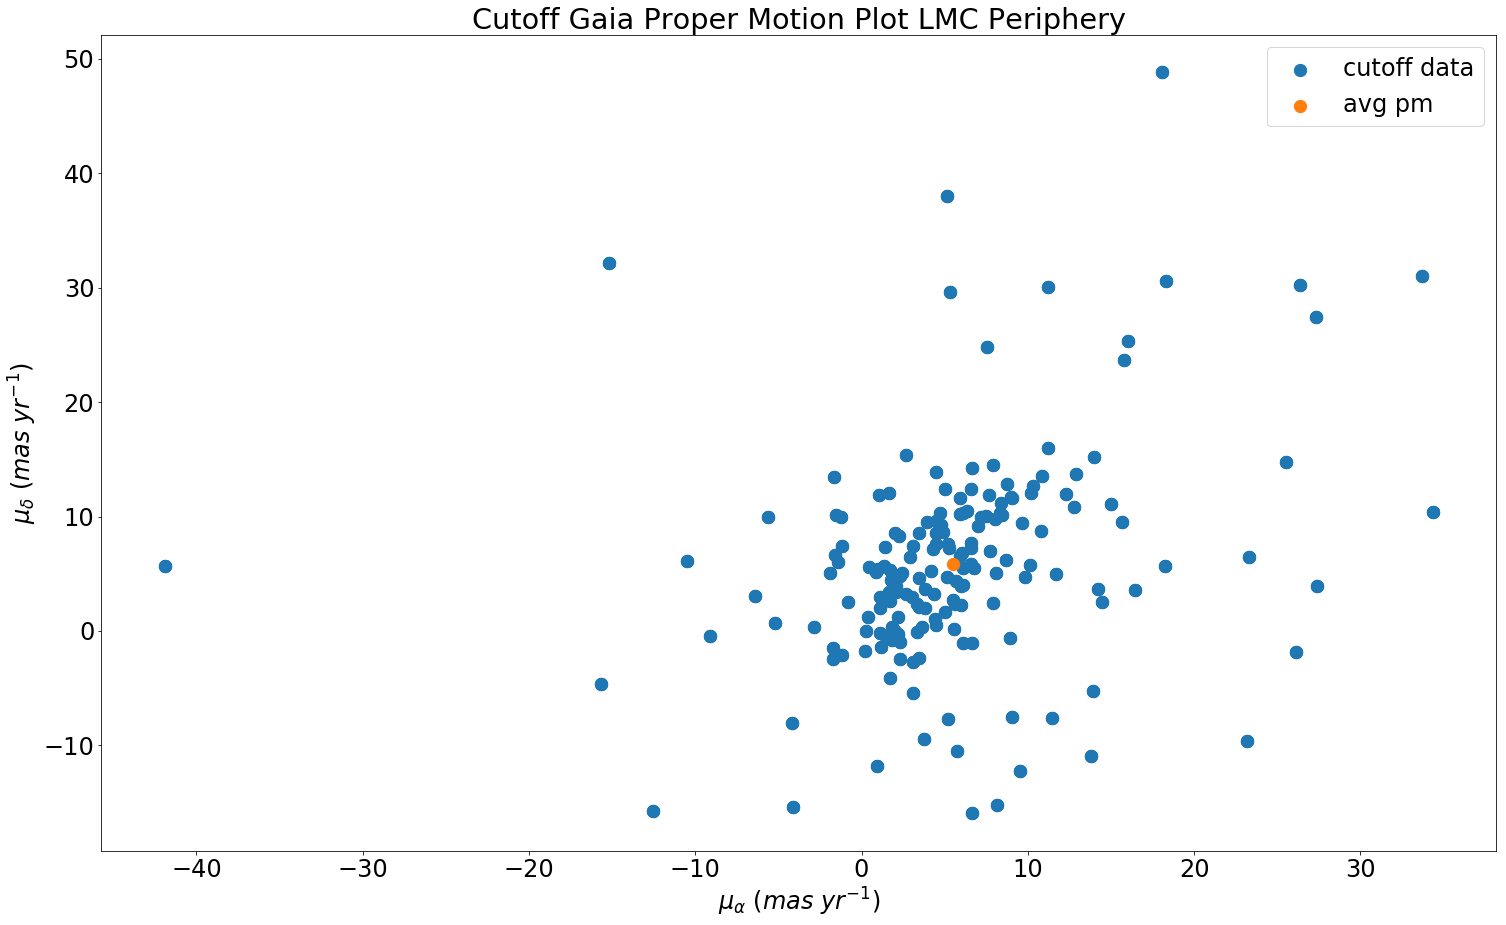

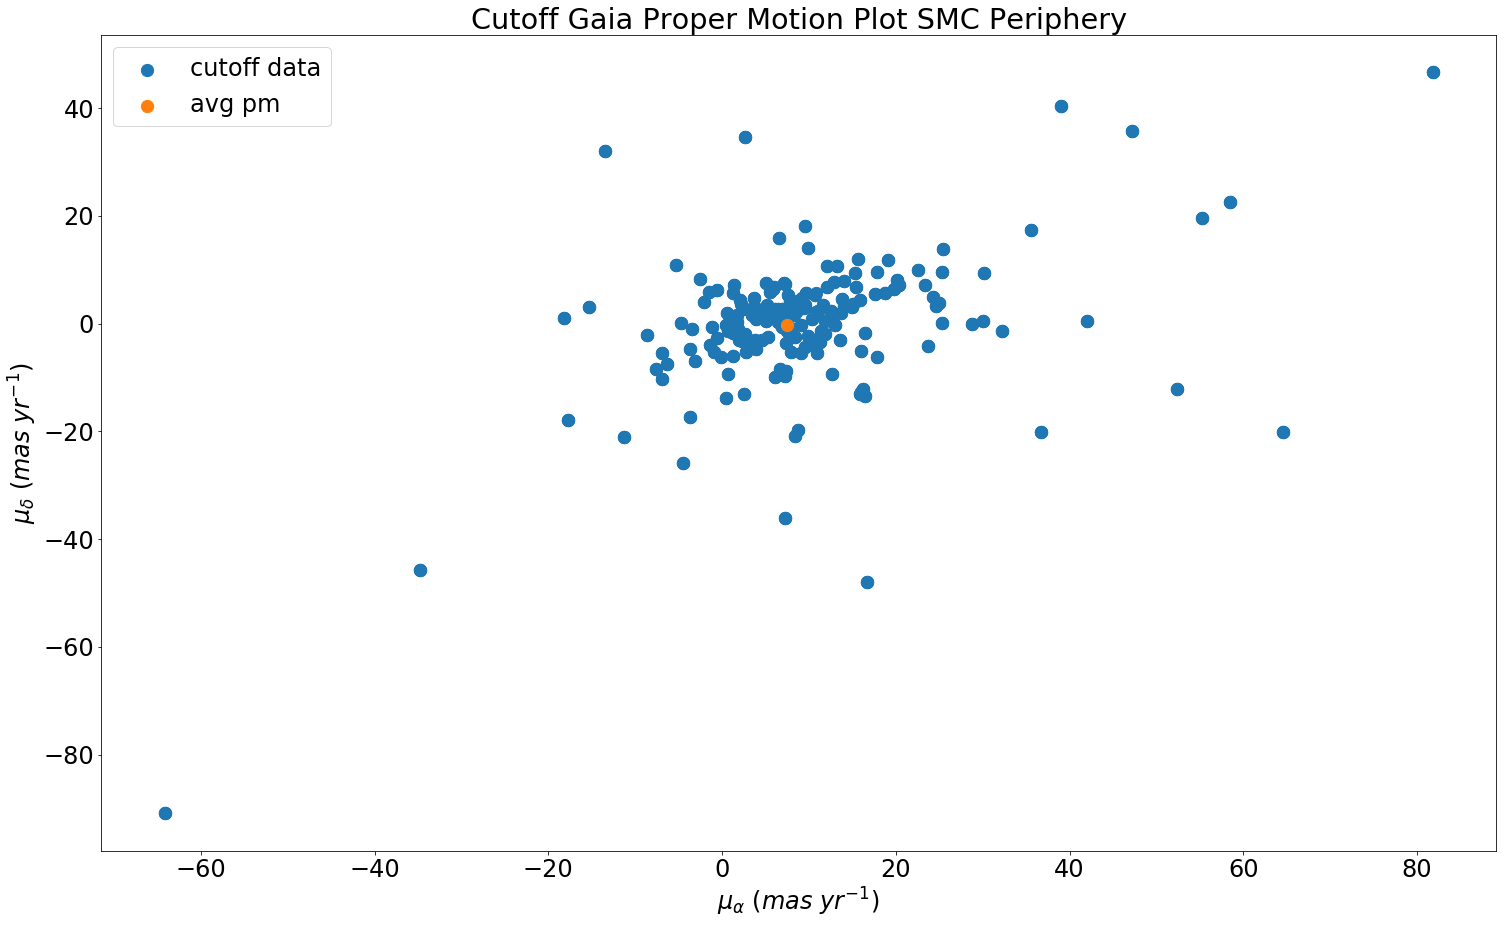

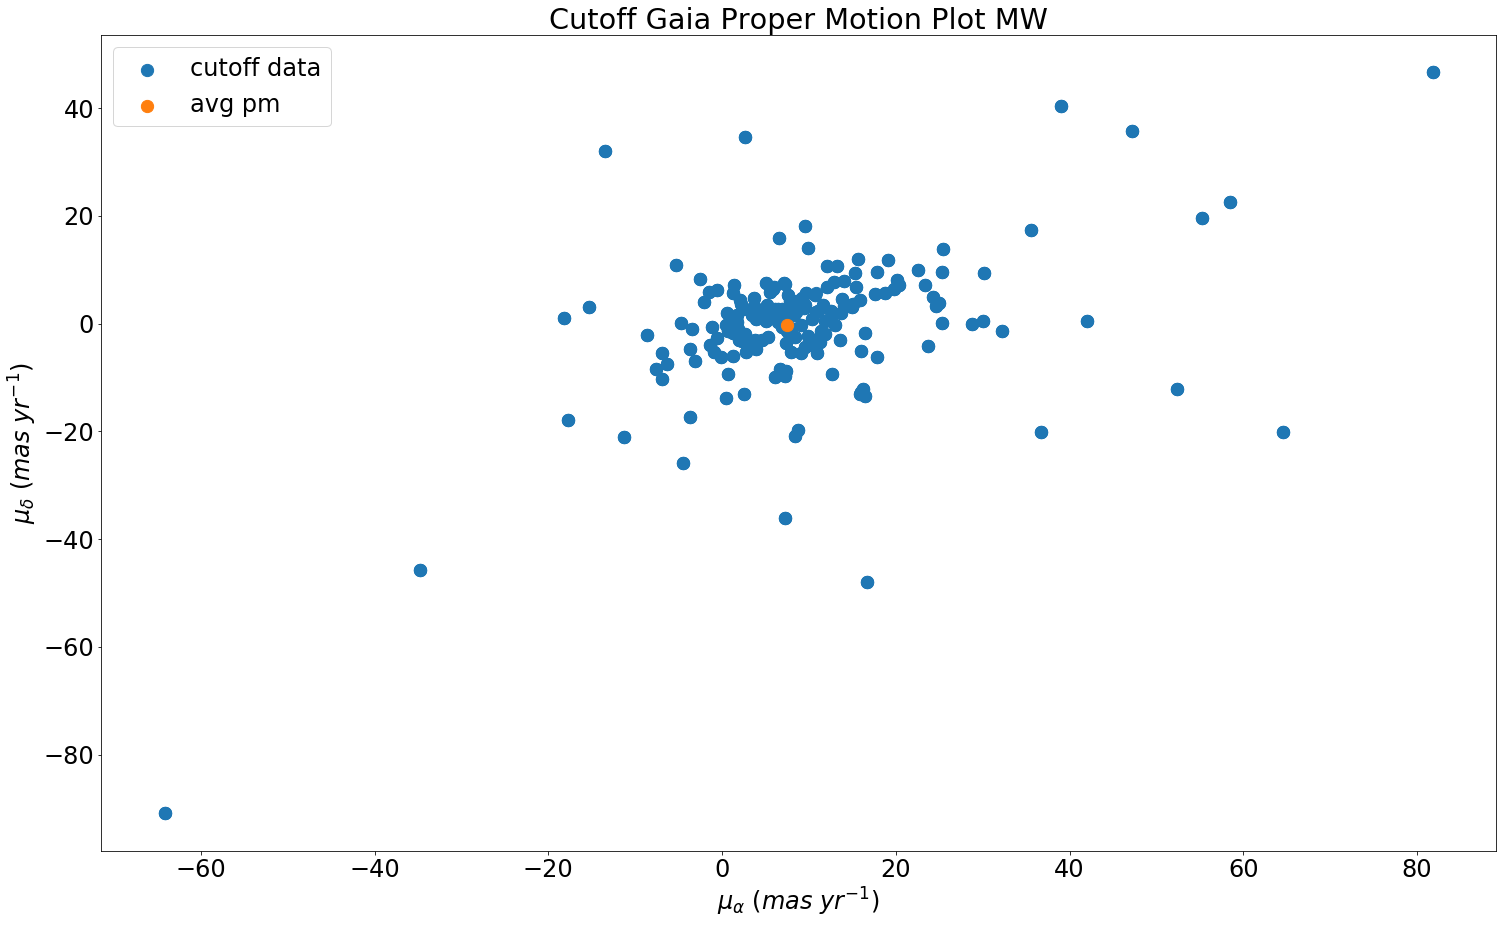

In [9]:
###Plots for proper motion in periphery after magnitude cutoff

#Cutoff lpmdec, lpmra
plt.figure(figsize=[25,15])
plt.scatter(clean_lpmra,clean_lpmdec,s=150,label='cutoff data')
plt.scatter(np.nanmean(clean_lpmra),np.nanmean(clean_lpmdec),s=150,label='avg pm')
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('$\mu_{\delta}$ $(mas$ $yr^{-1}$)')
plt.title('Cutoff Gaia Proper Motion Plot LMC Periphery')
plt.savefig('cutlmcpm.pdf',bbox_inches='tight')
plt.legend()
plt.show()

#Cutoff spmdec, spmra
plt.figure(figsize=[25,15])
plt.scatter(clean_spmra,clean_spmdec,s=150,label='cutoff data')
plt.scatter(np.nanmean(clean_spmra),np.nanmean(clean_spmdec),s=150,label='avg pm')
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('$\mu_{\delta}$ $(mas$ $yr^{-1}$)')
plt.title('Cutoff Gaia Proper Motion Plot SMC Periphery')
plt.savefig('cutsmcpm.pdf',bbox_inches='tight')
plt.legend()
plt.show()

#Cutoff mpmdec, mpmra
plt.figure(figsize=[25,15])
plt.scatter(clean_spmra,clean_spmdec,s=150,label='cutoff data')
plt.scatter(np.nanmean(clean_spmra),np.nanmean(clean_spmdec),s=150,label='avg pm')
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('$\mu_{\delta}$ $(mas$ $yr^{-1}$)')
plt.title('Cutoff Gaia Proper Motion Plot MW')
plt.savefig('cutsmcpm.pdf',bbox_inches='tight')
plt.legend()
plt.show()

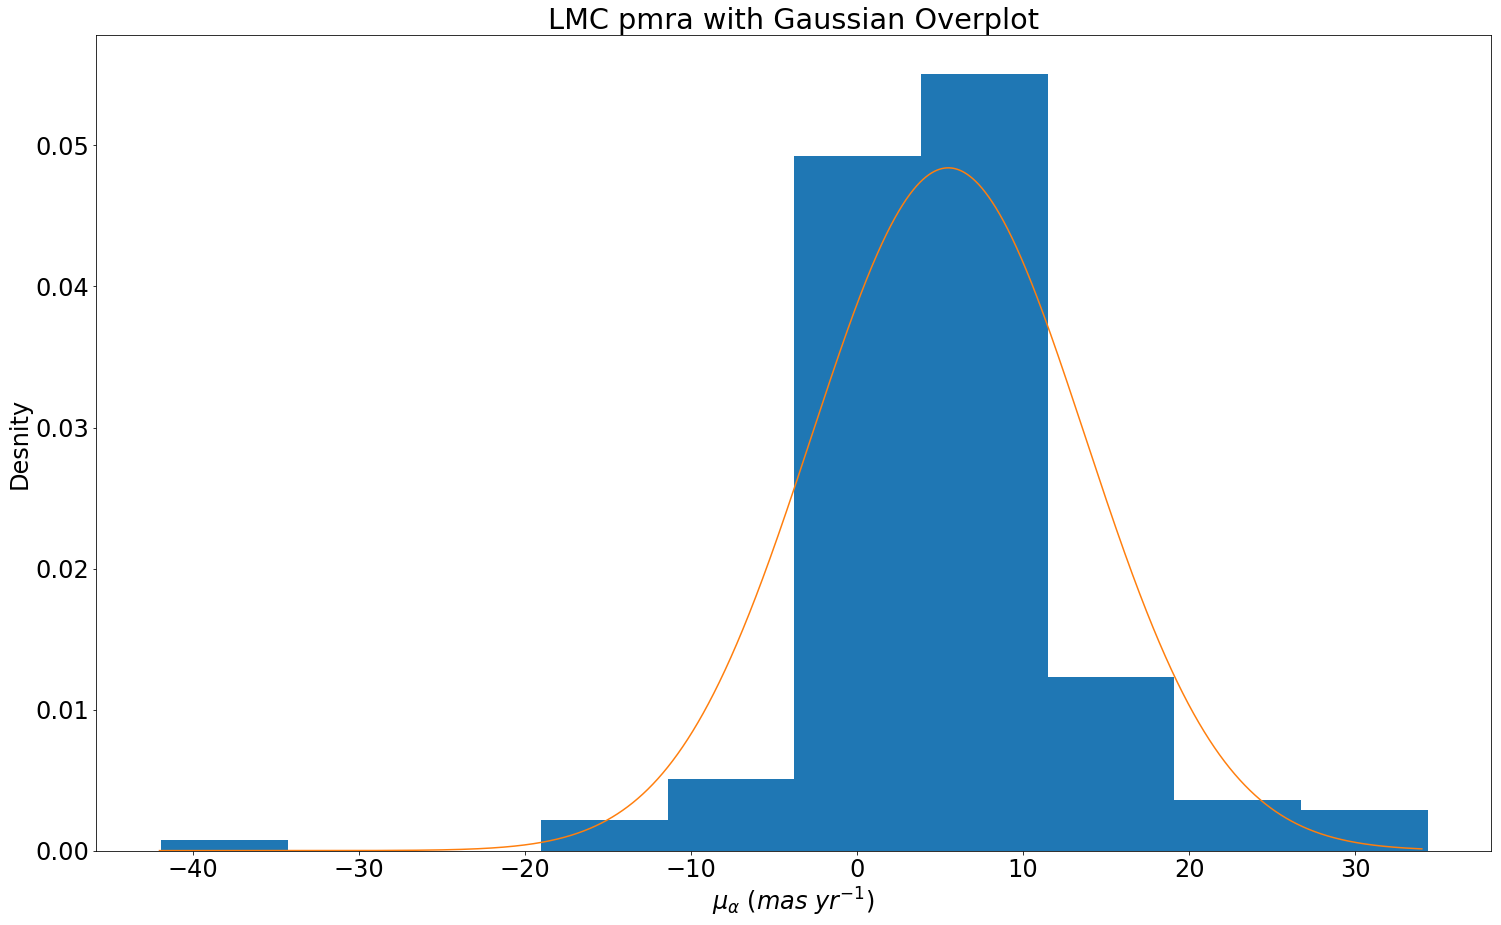

mean = 5.49265451553054
std = 8.24039882506496
skew = -0.2804513944009641
kurt = 7.125883883135888
median = 4.7548708103663415
IQR = 6.518326701956746
MAD = 3.085641564991437


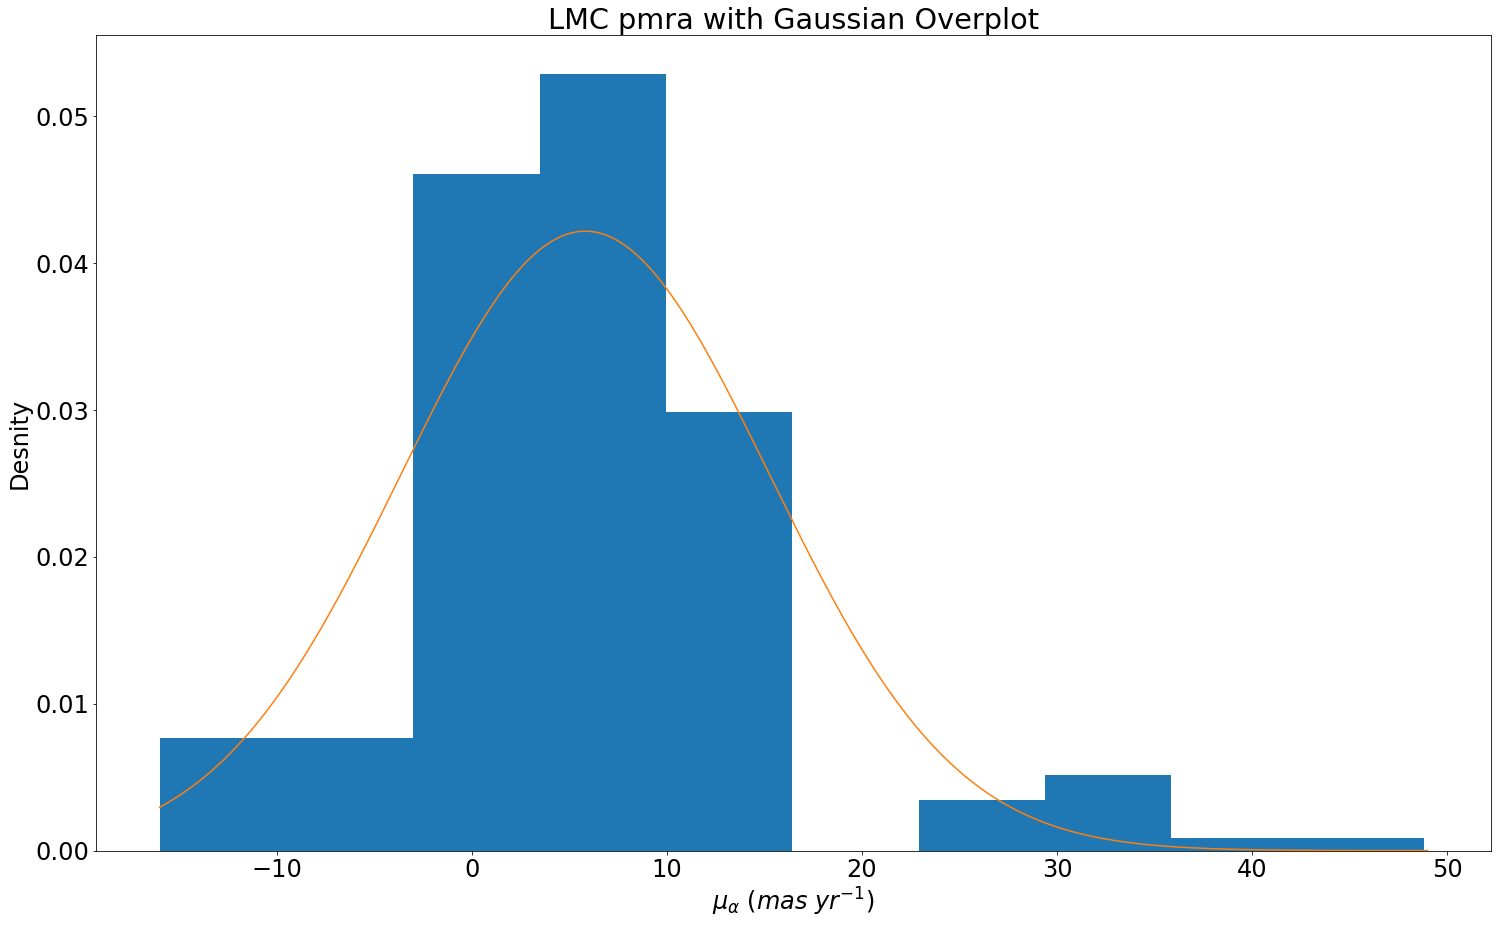

mean = 5.819835078444064
std = 9.457135937498196
skew = 1.0050603635753828
kurt = 3.2264210720004174
median = 5.23812786456411
IQR = 9.705494040302154
MAD = 4.8836845402804485


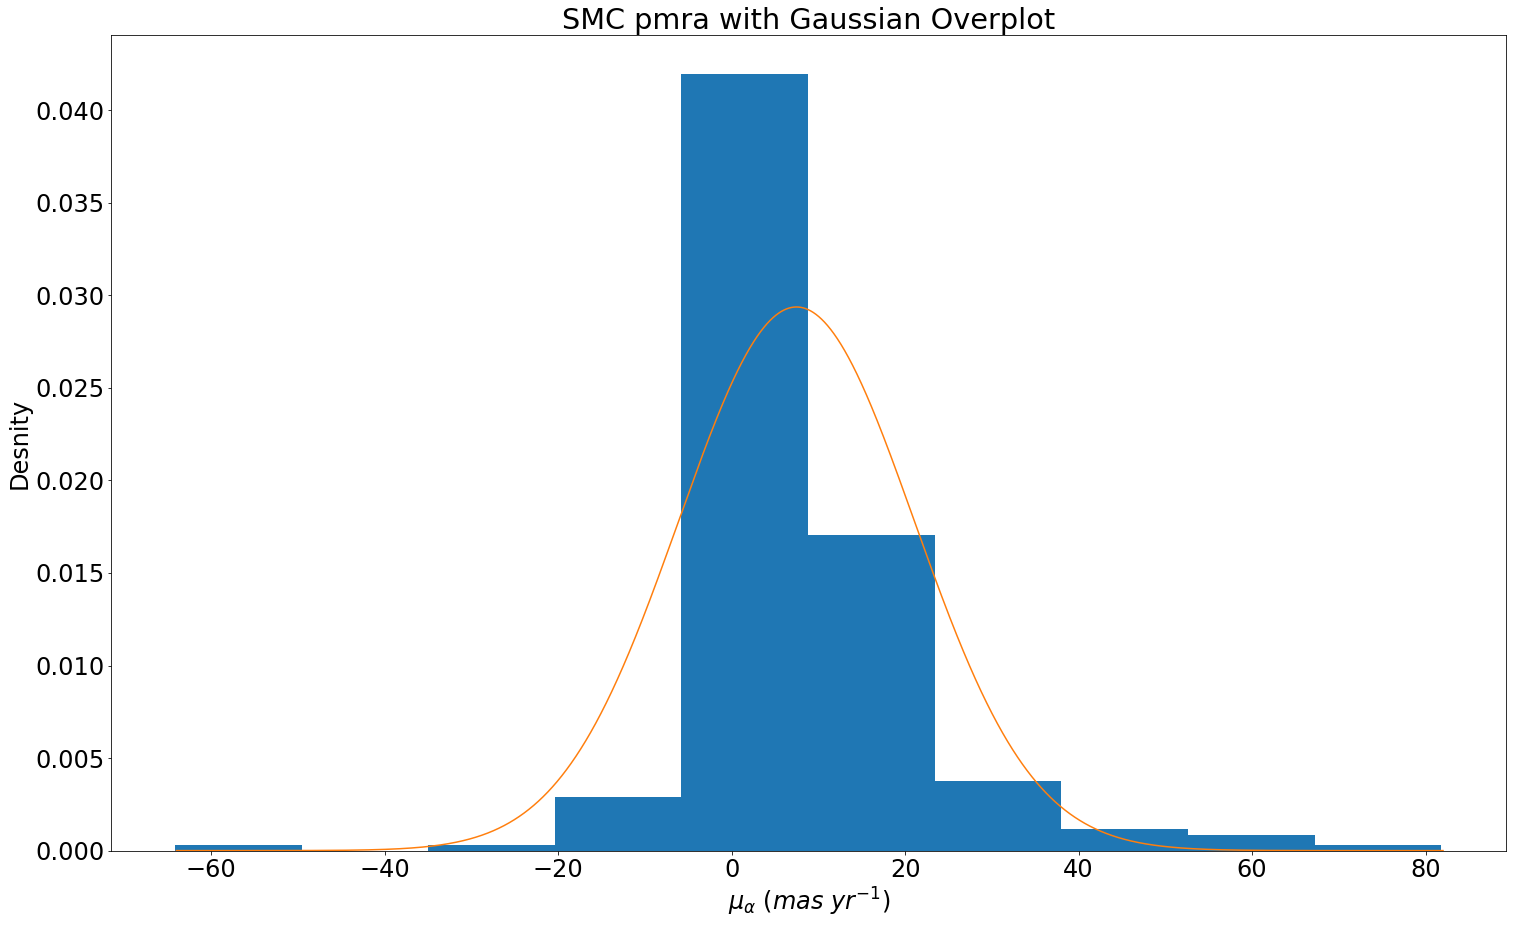

mean = 7.471780595707509
std = 13.581394150373978
skew = 1.1207076121178758
kurt = 8.968279575840855
median = 4.565255553616631
IQR = 10.46211645060788
MAD = 3.8820275212623696


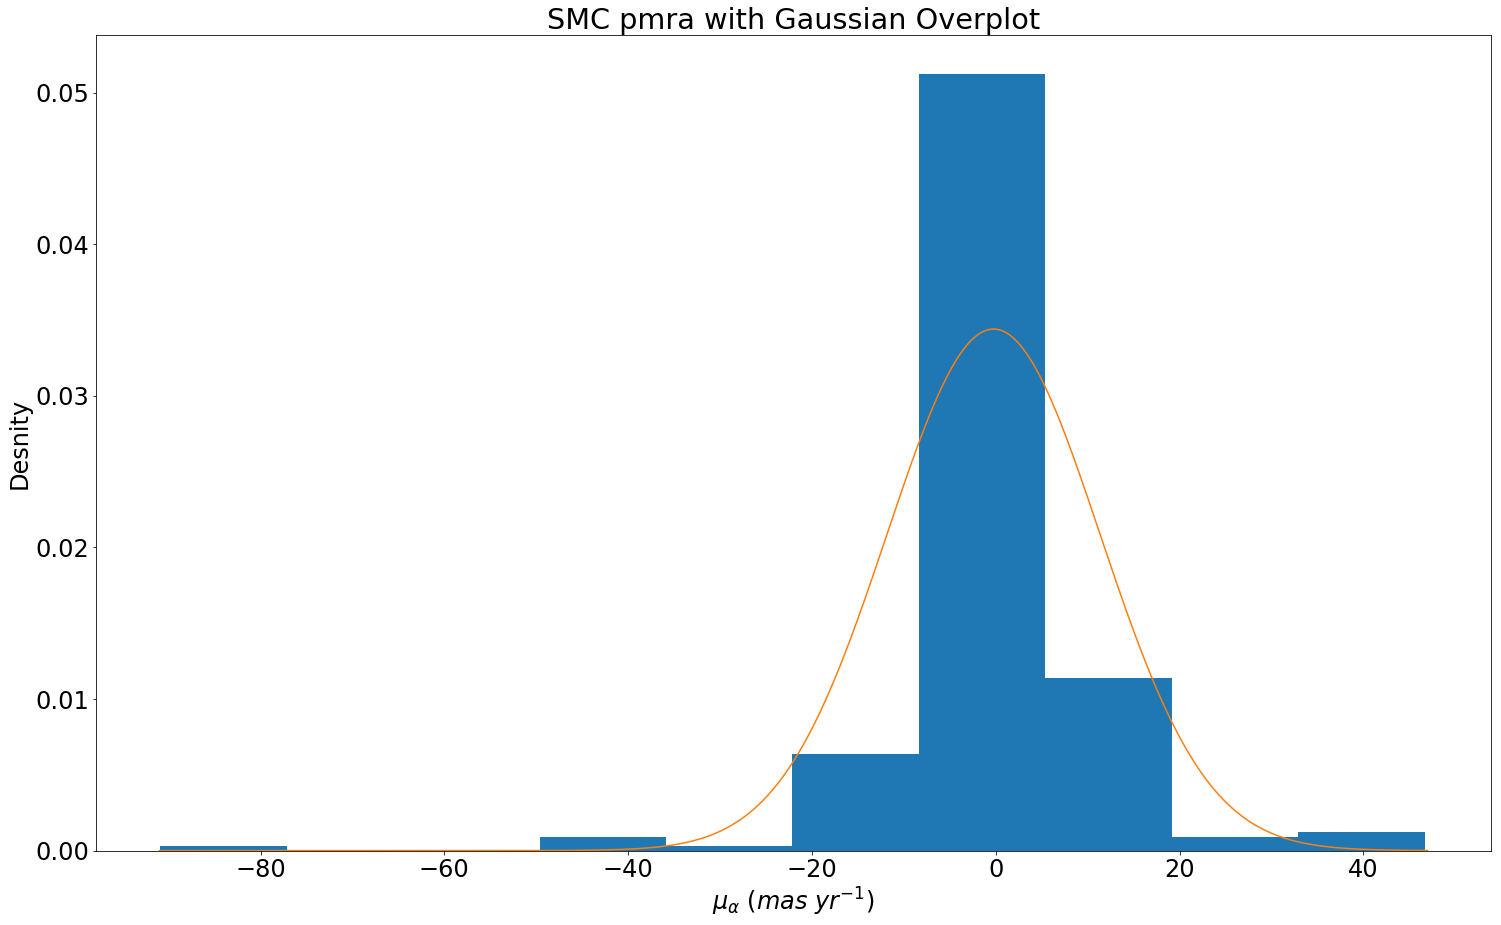

mean = -0.23999055330193836
std = 11.592548356136604
skew = -1.9621291123473492
kurt = 18.64266757433497
median = -0.9323821311400815
IQR = 5.636697346841106
MAD = 3.1696209165860125


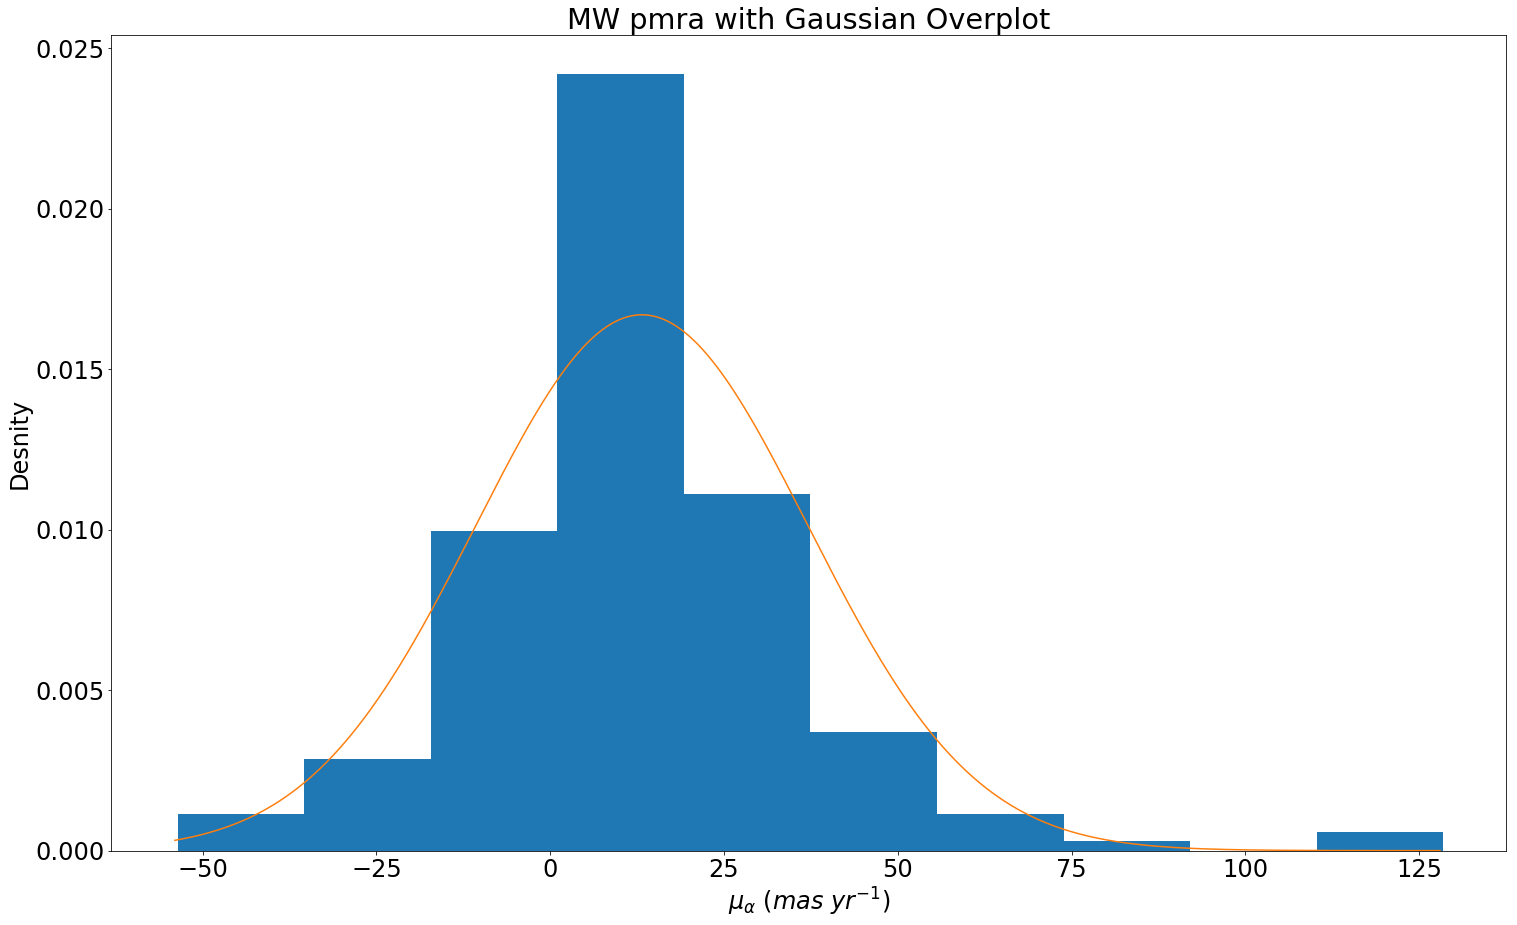

mean = 13.182020725388602
std = 23.894164994557464
skew = 1.0285631076581796
kurt = 4.88780972446622
median = 13.38
IQR = 21.560000000000002
MAD = 10.230000000000002


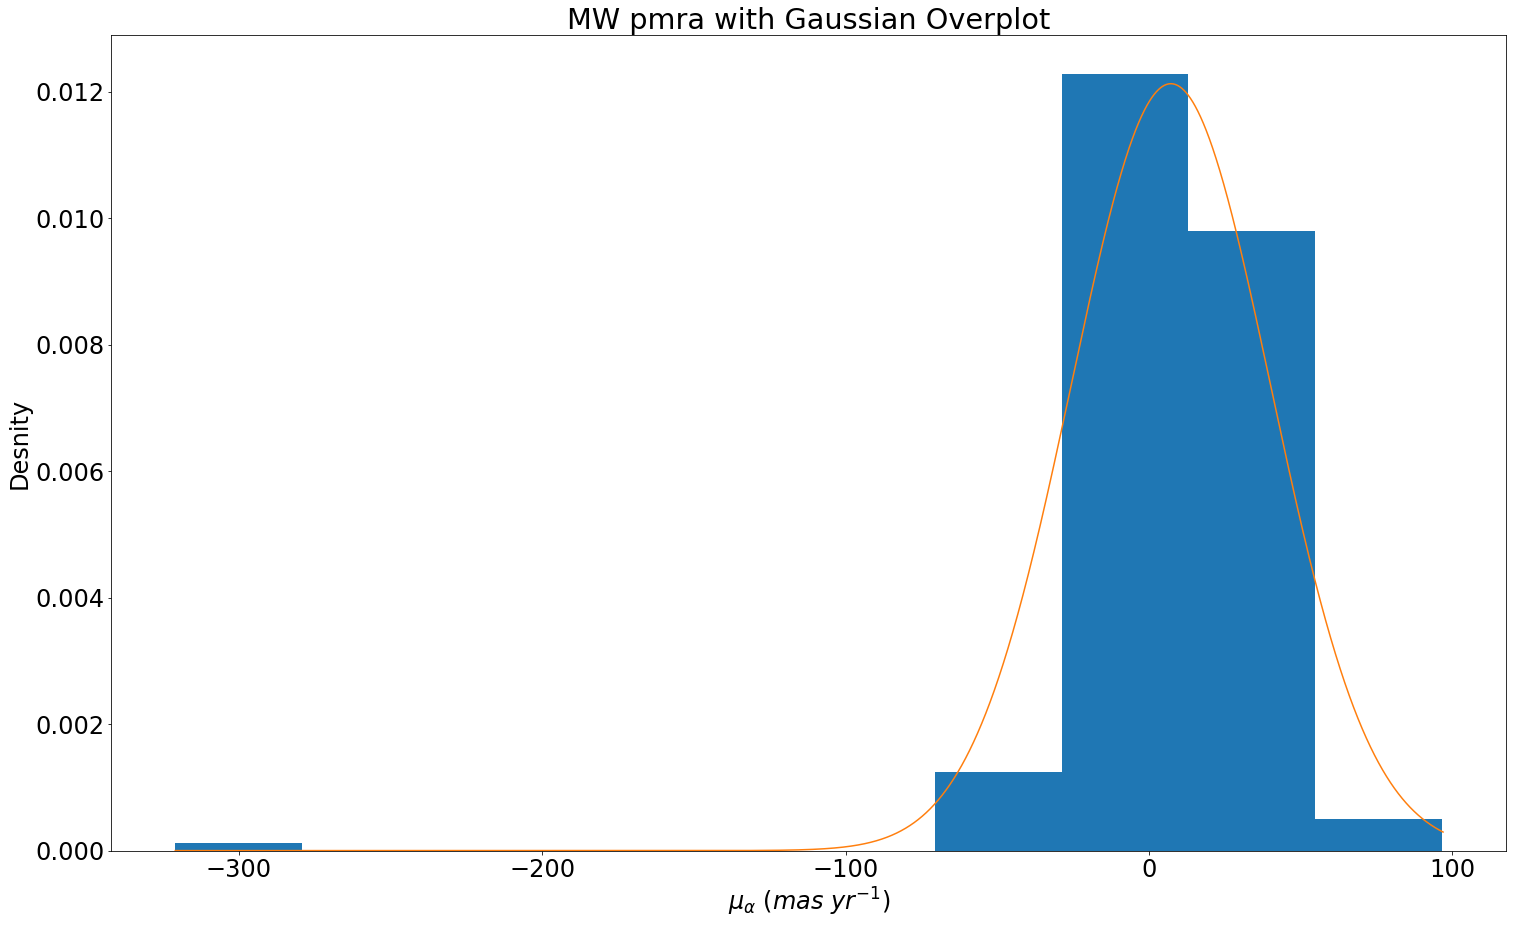

mean = 7.260932642487046
std = 32.895144170698
skew = -5.097590243602001
kurt = 49.52538684180522
median = 10.280000000000001
IQR = 26.990000000000002
MAD = 13.899999999999999


In [11]:
###Histogram for proper motion in periphery after magnitude cutoff

def mad(xdata):
    return np.median(np.absolute(xdata-np.median(xdata)))

def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2.)

#LMC histograms
clean_lpmra = [x for x in clean_lpmra if str(x) != 'nan'] #remember to remove nan
avg_lpmra = np.mean(clean_lpmra)
sig_lpmra = np.std(clean_lpmra)
z_lra = np.linspace(round(min(clean_lpmra)),round(max(clean_lpmra)),10000)

clean_lpmdec = [x for x in clean_lpmdec if str(x) != 'nan']
avg_lpmdec = np.mean(clean_lpmdec)
sig_lpmdec = np.std(clean_lpmdec)
z_ldec = np.linspace(round(min(clean_lpmdec)),round(max(clean_lpmdec)),10000)

plt.figure(figsize=[25,15])
plt.hist(clean_lpmra, density=True)
plt.plot(z_lra,gaussian(z_lra,avg_lpmra,sig_lpmra))
plt.title('LMC pmra with Gaussian Overplot')
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('Desnity')
plt.savefig('cutlmcpmra.pdf',bbox_inches='tight')
plt.show()

print('mean = '+ str(np.mean(clean_lpmra)))
print('std = '+ str(np.std(clean_lpmra)))
print('skew = '+ str(skew(clean_lpmra)))
print('kurt = '+ str(kurtosis(clean_lpmra)))
print('median = '+ str(np.median(clean_lpmra)))
print('IQR = '+ str(iqr(clean_lpmra)))
print('MAD = '+str(mad(clean_lpmra)))

plt.figure(figsize=[25,15])
plt.hist(clean_lpmdec, density=True)
plt.plot(z_ldec,gaussian(z_ldec,avg_lpmdec,sig_lpmdec))
plt.title('LMC pmra with Gaussian Overplot')
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('Desnity')
plt.savefig('cutlmcpmdec.pdf',bbox_inches='tight')
plt.show()

print('mean = '+ str(np.mean(clean_lpmdec)))
print('std = '+ str(np.std(clean_lpmdec)))
print('skew = '+ str(skew(clean_lpmdec)))
print('kurt = '+ str(kurtosis(clean_lpmdec)))
print('median = '+ str(np.median(clean_lpmdec)))
print('IQR = '+ str(iqr(clean_lpmdec)))
print('MAD = '+str(mad(clean_lpmdec)))



#SMC histograms
clean_spmra = [x for x in clean_spmra if str(x) != 'nan'] #remember to remove nan
avg_spmra = np.mean(clean_spmra)
sig_spmra = np.std(clean_spmra)
z_sra = np.linspace(round(min(clean_spmra)),round(max(clean_spmra)),10000)

clean_spmdec = [x for x in clean_spmdec if str(x) != 'nan']
avg_spmdec = np.mean(clean_spmdec)
sig_spmdec = np.std(clean_spmdec)
z_sdec = np.linspace(round(min(clean_spmdec)),round(max(clean_spmdec)),10000)

plt.figure(figsize=[25,15])
plt.hist(clean_spmra, density=True)
plt.plot(z_sra,gaussian(z_sra,avg_spmra,sig_spmra))
plt.title('SMC pmra with Gaussian Overplot')
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('Desnity')
plt.savefig('cutsmcpmra.pdf',bbox_inches='tight')
plt.show()

print('mean = '+ str(np.mean(clean_spmra)))
print('std = '+ str(np.std(clean_spmra)))
print('skew = '+ str(skew(clean_spmra)))
print('kurt = '+ str(kurtosis(clean_spmra)))
print('median = '+ str(np.median(clean_spmra)))
print('IQR = '+ str(iqr(clean_spmra)))
print('MAD = '+str(mad(clean_spmra)))

plt.figure(figsize=[25,15])
plt.hist(clean_spmdec, density=True)
plt.plot(z_sdec,gaussian(z_sdec,avg_spmdec,sig_spmdec))
plt.title('SMC pmra with Gaussian Overplot')
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('Desnity')
plt.savefig('cutsmcpmdec.pdf',bbox_inches='tight')
plt.show()

print('mean = '+ str(np.mean(clean_spmdec)))
print('std = '+ str(np.std(clean_spmdec)))
print('skew = '+ str(skew(clean_spmdec)))
print('kurt = '+ str(kurtosis(clean_spmdec)))
print('median = '+ str(np.median(clean_spmdec)))
print('IQR = '+ str(iqr(clean_spmdec)))
print('MAD = '+str(mad(clean_spmdec)))



#MW histograms
clean_mpmra = [x for x in clean_mpmra if str(x) != 'nan'] #remember to remove nan
avg_mpmra = np.mean(clean_mpmra)
sig_mpmra = np.std(clean_mpmra)
z_mra = np.linspace(round(min(clean_mpmra)),round(max(clean_mpmra)),10000)

clean_mpmdec = [x for x in clean_mpmdec if str(x) != 'nan']
avg_mpmdec = np.mean(clean_mpmdec)
sig_mpmdec = np.std(clean_mpmdec)
z_mdec = np.linspace(round(min(clean_mpmdec)),round(max(clean_mpmdec)),10000)

plt.figure(figsize=[25,15])
plt.hist(clean_mpmra, density=True)
plt.plot(z_mra,gaussian(z_mra,avg_mpmra,sig_mpmra))
plt.title('MW pmra with Gaussian Overplot')
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('Desnity')
plt.savefig('cutmwpmra.pdf',bbox_inches='tight')
plt.show()

print('mean = '+ str(np.mean(clean_mpmra)))
print('std = '+ str(np.std(clean_mpmra)))
print('skew = '+ str(skew(clean_mpmra)))
print('kurt = '+ str(kurtosis(clean_mpmra)))
print('median = '+ str(np.median(clean_mpmra)))
print('IQR = '+ str(iqr(clean_mpmra)))
print('MAD = '+str(mad(clean_mpmra)))

plt.figure(figsize=[25,15])
plt.hist(clean_mpmdec, density=True)
plt.plot(z_mdec,gaussian(z_mdec,avg_mpmdec,sig_mpmdec))
plt.title('MW pmra with Gaussian Overplot')
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('Desnity')
plt.savefig('cutmwpmdec.pdf',bbox_inches='tight')
plt.show()

print('mean = '+ str(np.mean(clean_mpmdec)))
print('std = '+ str(np.std(clean_mpmdec)))
print('skew = '+ str(skew(clean_mpmdec)))
print('kurt = '+ str(kurtosis(clean_mpmdec)))
print('median = '+ str(np.median(clean_mpmdec)))
print('IQR = '+ str(iqr(clean_mpmdec)))
print('MAD = '+str(mad(clean_mpmdec)))

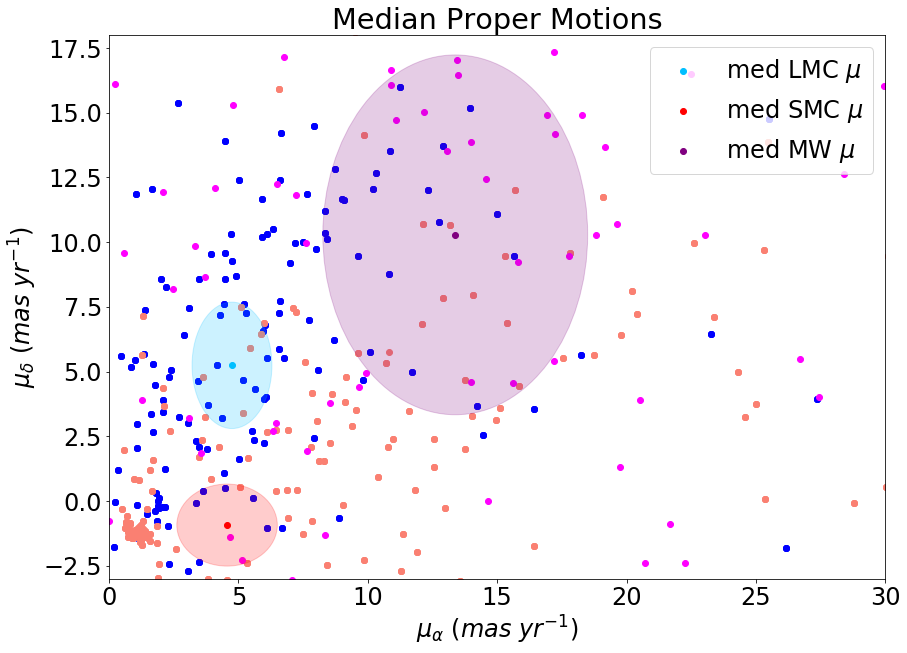

In [12]:
from matplotlib.patches import Ellipse, Rectangle

pmra_dat = [np.median(clean_lpmra),np.median(clean_spmra),np.median(clean_mpmra)]
pmdec_dat = [np.median(clean_lpmdec),np.median(clean_spmdec),np.median(clean_mpmdec)]

ells = [Ellipse((pmra_dat[0], pmdec_dat[0]),mad(clean_lpmra),mad(clean_lpmdec),0,color='deepskyblue'),Ellipse((pmra_dat[1], pmdec_dat[1]),mad(clean_spmra),mad(clean_spmdec),0,color='red'),Ellipse((pmra_dat[2], pmdec_dat[2]),mad(clean_mpmra),mad(clean_mpmdec),0,color='purple')]

plt.figure(figsize=[15,10])
a = plt.subplot(111, aspect='equal')

for e in ells:
    e.set_clip_box(a.bbox)
    e.set_alpha(0.2)
    a.add_artist(e)

plt.scatter(pmra_dat[0],pmdec_dat[0],c='deepskyblue',label='med LMC $\mu$')
plt.scatter(pmra_dat[1],pmdec_dat[1],c='red',label='med SMC $\mu$')
plt.scatter(pmra_dat[2],pmdec_dat[2],c='purple',label='med MW $\mu$')
plt.scatter(clean_lpmra,clean_lpmdec,c='b')
plt.scatter(clean_spmra,clean_spmdec,c='salmon')
plt.scatter(clean_mpmra,clean_mpmdec,c='fuchsia')
plt.title('Median Proper Motions')
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('$\mu_{\delta}$ $(mas$ $yr^{-1}$)')
plt.xlim(0,30)
plt.ylim(-3,18)
plt.savefig('cutmedians.pdf',bbox_inches='tight')
plt.legend()
plt.show()

In [ ]:
###CMD For LMC,SMC,MW data

#lmcper
#lcolor = np.sqrt(np.square(lmcper['pmra'])+np.square(lmcper['pmdec']))
plt.figure(figsize=[25,20])
plt.scatter(lmcper['bp_rp'],lmcper['phot_bp_mean_mag'])
plt.title('LMC Periphery CMD')
plt.xlabel('$G_{BP} - G_{RP}$')
plt.ylabel('$G_{BP}$')
plt.ylim(24,8)
#plt.savefig('lmcbprpbp.pdf',bbox_inches='tight')

plt.figure(figsize=[25,20])
plt.scatter(lmcper['bp_g'],lmcper['phot_bp_mean_mag'])
plt.title('LMC Periphery CMD')
plt.xlabel('$G_{BP} - G$')
plt.ylabel('$G_{BP}$')
plt.ylim(24,8)
#plt.savefig('lmcbpgg.pdf',bbox_inches='tight')

plt.figure(figsize=[25,20])
plt.scatter(lmcper['bp_g'],lmcper['phot_g_mean_mag'])
plt.title('LMC Periphery CMD')
plt.xlabel('$G_{BP} - G$')
plt.ylabel('$G$')
plt.ylim(22,7.5)
#plt.savefig('lmcbpgg.pdf',bbox_inches='tight')

plt.figure(figsize=[25,20])
plt.scatter(lmcper['g_rp'],lmcper['phot_g_mean_mag'])
plt.title('LMC Periphery CMD')
plt.xlabel('$G - G_{RP}$')
plt.ylabel('$G$')
plt.ylim(22,7.5)
#plt.savefig('lmcbpgg.pdf',bbox_inches='tight')

plt.figure(figsize=[25,20])
plt.scatter(lmcper['g_rp'],lmcper['phot_rp_mean_mag'])
plt.title('LMC Periphery CMD')
plt.xlabel('$G - G_{RP}$')
plt.ylabel('$G_{RP}$')
plt.ylim(22,6)
#plt.savefig('lmcbpgg.pdf',bbox_inches='tight')

plt.figure(figsize=[25,20])
plt.scatter(lmcper['bp_rp'],lmcper['phot_rp_mean_mag'])
plt.title('LMC Periphery CMD')
plt.xlabel('$G_{BP} - G_{RP}$')
plt.ylabel('$G_{RP}$')
plt.ylim(22,6)
#plt.savefig('lmcbpgg.pdf',bbox_inches='tight')

#smcper
plt.figure(figsize=[25,20])
plt.scatter(smcper['bp_rp'],smcper['phot_bp_mean_mag'])
plt.title('SMC Periphery CMD')
plt.xlabel('$G_{BP} - G_{RP}$')
plt.ylabel('$G_{BP}$')
plt.ylim(24,8)
plt.savefig('smcbprpbp.pdf',bbox_inches='tight')

plt.figure(figsize=[25,20])
plt.scatter(lmcper['bp_g'],lmcper['phot_bp_mean_mag'])
plt.title('LMC Periphery CMD')
plt.xlabel('$G_{BP} - G$')
plt.ylabel('$G_{BP}$')
plt.ylim(24,8)
#plt.savefig('lmcbpgg.pdf',bbox_inches='tight')

plt.figure(figsize=[25,20])
plt.scatter(lmcper['bp_g'],lmcper['phot_g_mean_mag'])
plt.title('LMC Periphery CMD')
plt.xlabel('$G_{BP} - G$')
plt.ylabel('$G$')
plt.ylim(22,7.5)
#plt.savefig('lmcbpgg.pdf',bbox_inches='tight')

plt.figure(figsize=[25,20])
plt.scatter(smcper['g_rp'],smcper['phot_g_mean_mag'])
plt.title('SMC Periphery CMD')
plt.xlabel('$G - G_{RP}$')
plt.ylabel('$G$')
plt.ylim(22,7.5)
#plt.savefig('lmcbpgg.pdf',bbox_inches='tight')

plt.figure(figsize=[25,20])
plt.scatter(smcper['g_rp'],smcper['phot_rp_mean_mag'])
plt.title('SMC Periphery CMD')
plt.xlabel('$G - G_{RP}$')
plt.ylabel('$G_{RP}$')
plt.ylim(22,6)
#plt.savefig('lmcbpgg.pdf',bbox_inches='tight')

plt.figure(figsize=[25,20])
plt.scatter(smcper['bp_rp'],smcper['phot_rp_mean_mag'])
plt.title('SMC Periphery CMD')
plt.xlabel('$G_{BP} - G_{RP}$')
plt.ylabel('$G_{RP}$')
plt.ylim(22,6)
#plt.savefig('lmcbpgg.pdf',bbox_inches='tight')

#MW
plt.figure(figsize=[25,20])
plt.scatter(bes['B-V'],bes['V'])
plt.title('MW CMD for $B-V$ and $V$')
plt.xlabel('$B-V$')
plt.ylabel('$V$')
plt.ylim(18.5,10)
plt.savefig('mwbvv.pdf',bbox_inches='tight')


In [54]:
###Create color magnitude cutoff function

def cutmagid(color, magnitude, cut, desig):
    data = []
    clean1 = []
    clean2 = []
    cutdat = []
    x = []
    y = []
    z = []
    for j0 in range(len(color)):
        data.append([color[j0],magnitude[j0],desig[j0]])
    
    for j1 in range(len(data)):
        if np.isfinite(data[j1][0]) == True:
            clean1.append(data[j1])
    
    for j2 in range(len(clean1)):
        if np.isfinite(clean1[j2][1]) == True:
            clean2.append(clean1[j2])
            
    for j3 in range(len(clean2)):
        if clean2[j3][1] <= cut:
            cutdat.append(clean2[j3])
        
    for j4 in range(len(cutdat)):
        x.append(cutdat[j4][0])
        y.append(cutdat[j4][1])
        z.append(cutdat[j4][2])
    
    return x, y, z
        

In [24]:
###Import for Hess Diagram
from scipy.stats import binned_statistic_2d

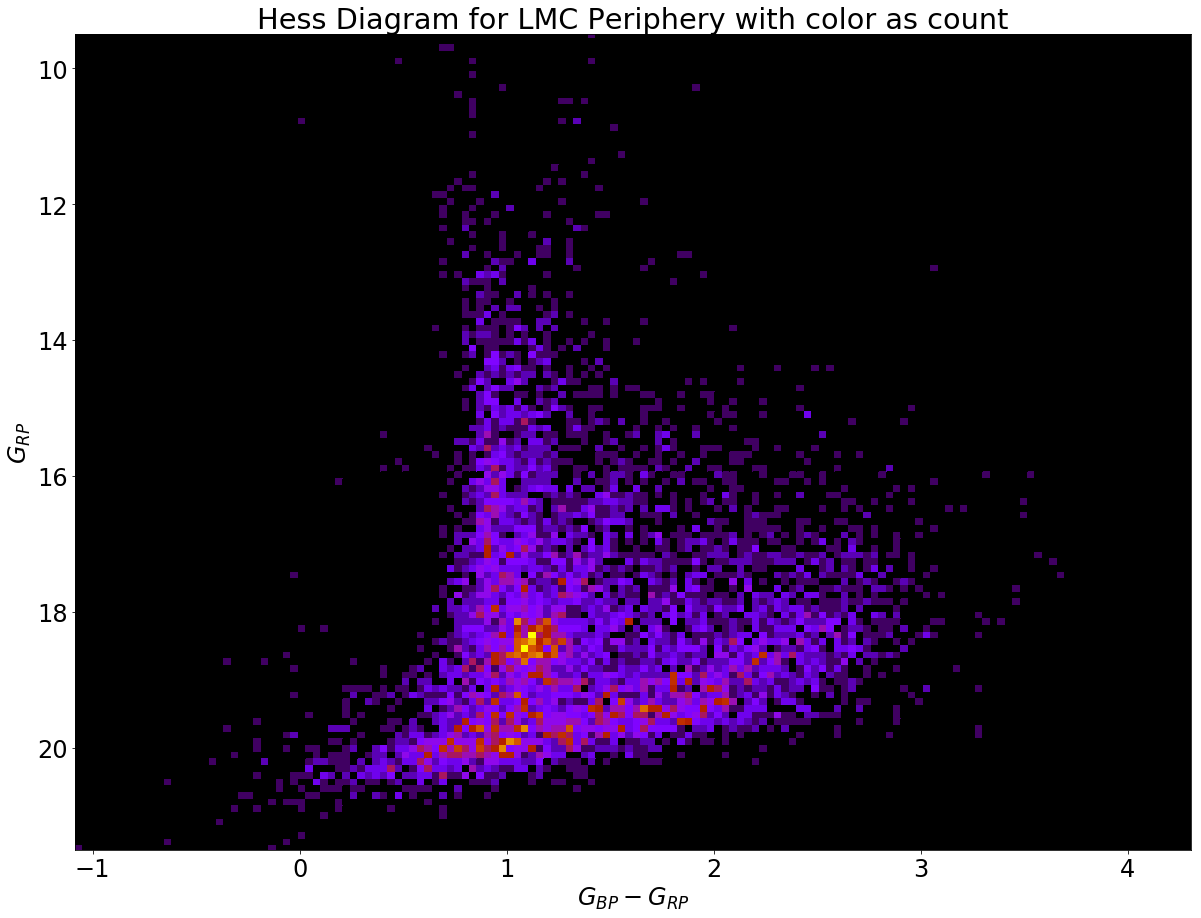

In [109]:
###Create Hess Diagram for LMC Periphery
lx, ly, lz = cutmagid(lmcper['bp_rp'],lmcper['phot_rp_mean_mag'],24,lmcper['designation'])

lhess = binned_statistic_2d(lx, ly, None, 'count',bins=150)

plt.figure(figsize=[20,15])
plt.pcolormesh(lhess.x_edge,lhess.y_edge,lhess.statistic.T,cmap='gnuplot')
plt.ylim(21.5,9.5)
plt.xlabel('$G_{BP}-G_{RP}$')
plt.ylabel('$G_{RP}$')
plt.title('Hess Diagram for LMC Periphery with color as count')
plt.show()

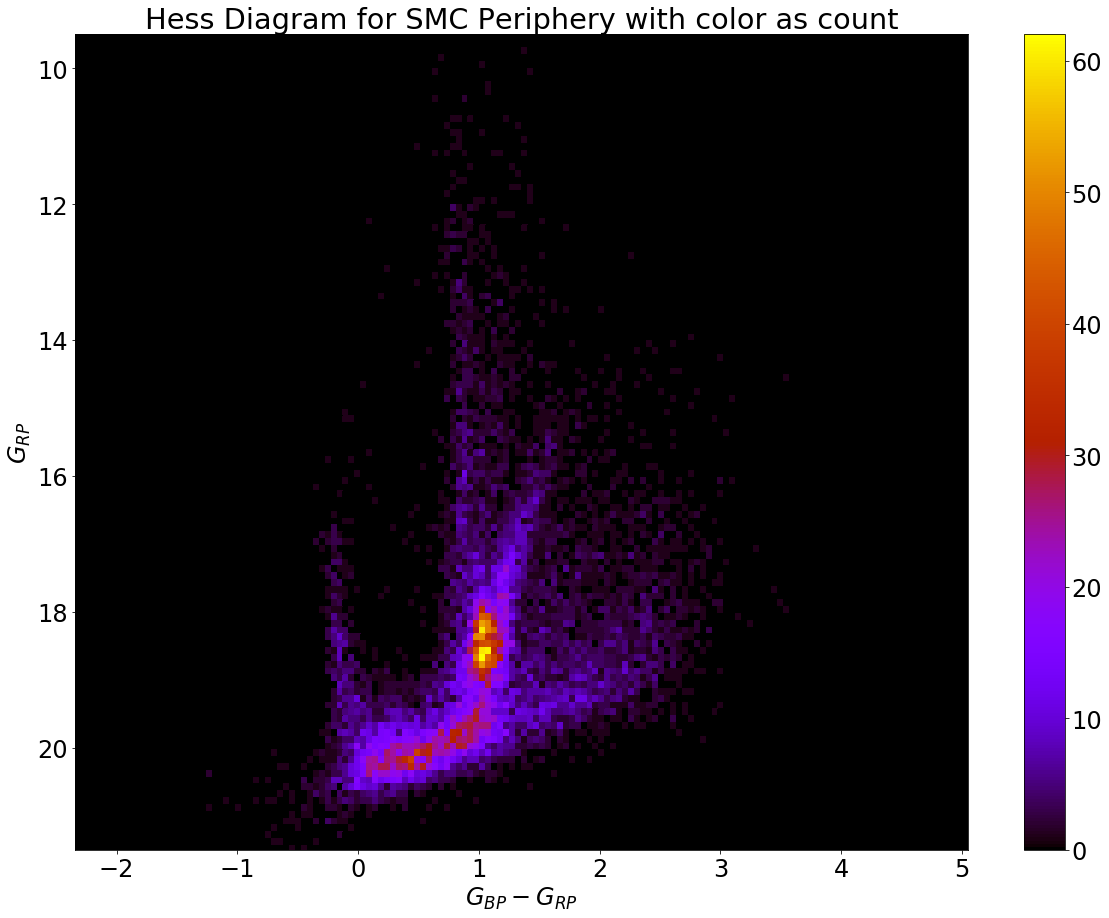

In [93]:
###Create Hess Diagram for LMC Periphery
sx, sy, sz = cutmagid(smcper['bp_rp'],smcper['phot_rp_mean_mag'],24, smcper['designation'])

shess = binned_statistic_2d(sx, sy, None, 'count',bins=150)

plt.figure(figsize=[20,15])
plt.pcolormesh(shess.x_edge,shess.y_edge,shess.statistic.T,cmap='gnuplot')
#plt.scatter(srgbcol,srgbmag,c='w',alpha=0.25)
plt.ylim(21.5,9.5)
plt.xlabel('$G_{BP}-G_{RP}$')
plt.ylabel('$G_{RP}$')
plt.title('Hess Diagram for SMC Periphery with color as count')
plt.colorbar()
plt.show()

In [59]:
###Rotated Ellipse equation
def rotell(x,y,h,k,a,b,theta):
    return (((x-h)*np.cos(theta)+(y-k)*np.sin(theta))/a)**2 + (((x-h)*np.sin(theta)-(y-k)*np.cos(theta))/b)**2 #<=1

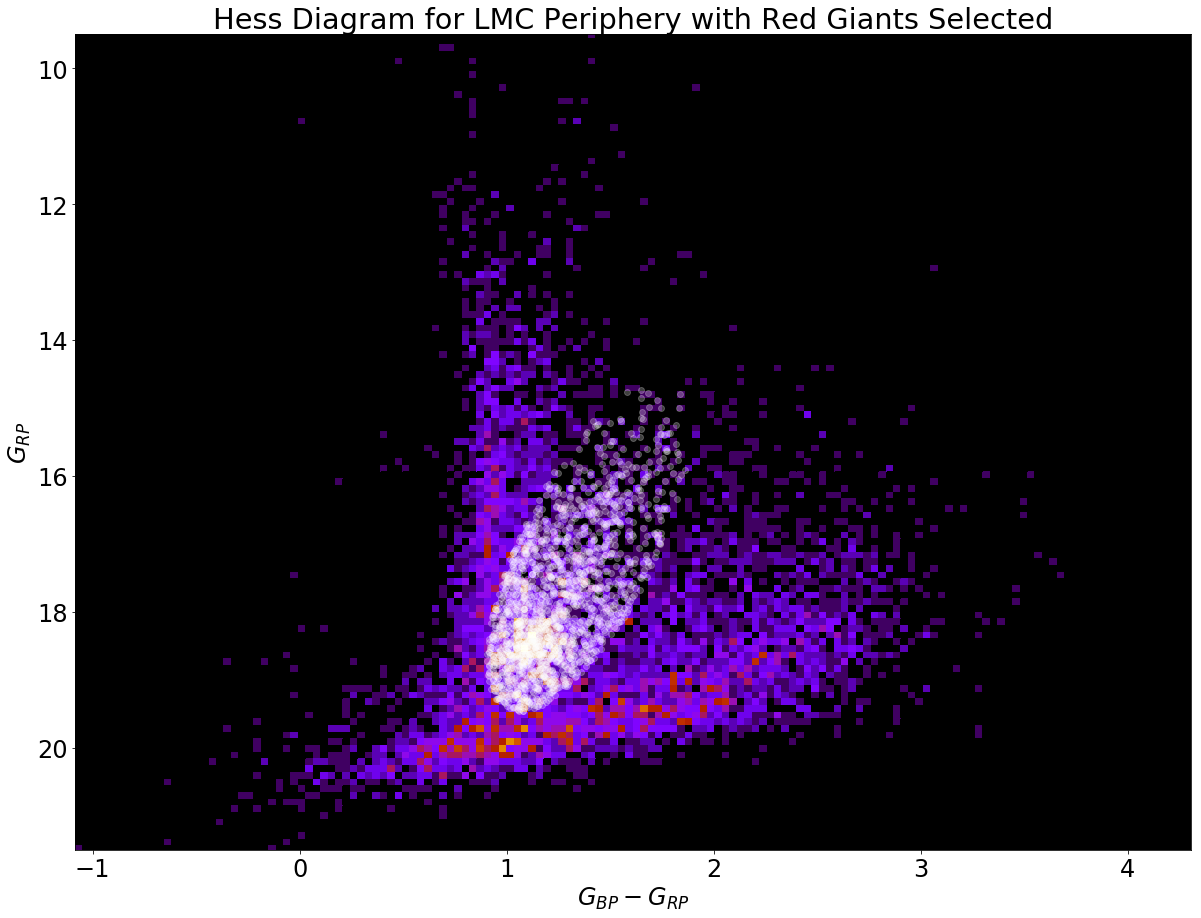

In [110]:
###Pick out the Red Giants in the LMC Periphery
lh = 1.4
lk = 17
la = 2.5
lb = 0.35
lt = np.pi/2 + 1/7
lrgbcol = []
lrgbmag = []
lrgbdes = []

for k0 in range(len(lx)):
    if rotell(lx[k0],ly[k0],lh,lk,la,lb,lt) <=1:
        lrgbcol.append(lx[k0])
        lrgbmag.append(ly[k0])
        lrgbdes.append(lz[k0])
        

plt.figure(figsize=[20,15])
plt.pcolormesh(lhess.x_edge,lhess.y_edge,lhess.statistic.T,cmap='gnuplot')
plt.scatter(lrgbcol,lrgbmag,c='w',alpha=0.25)
plt.ylim(21.5,9.5)
plt.xlabel('$G_{BP}-G_{RP}$')
plt.ylabel('$G_{RP}$')
plt.title('Hess Diagram for LMC Periphery with Red Giants Selected')
plt.show()

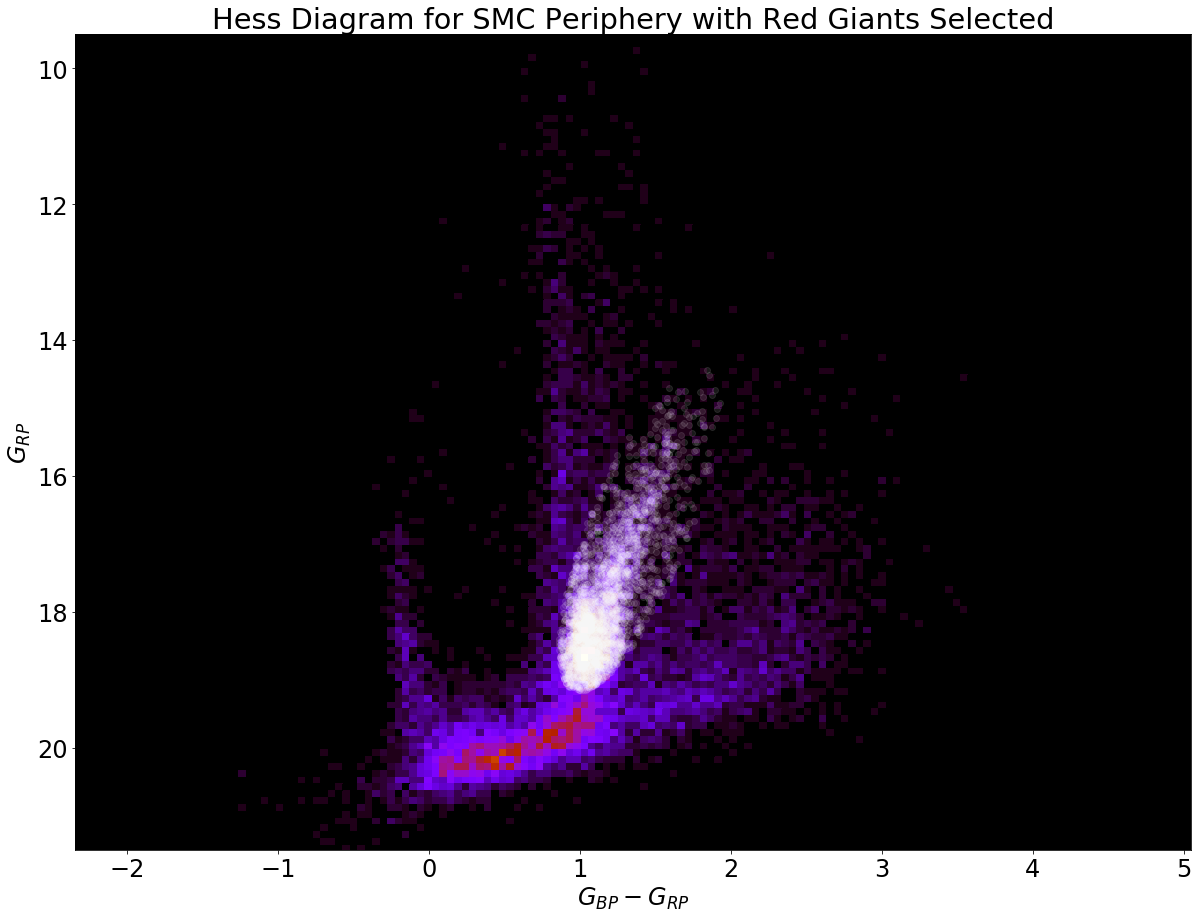

In [96]:
###Pick out the Red Giants in the SMC Periphery
sh = 1.4
sk = 16.7
sa = 2.5
sb = 0.35
st = np.pi/2 + 1/6
srgbcol = []
srgbmag = []
srgbdes = []

for k0 in range(len(sx)):
    if rotell(sx[k0],sy[k0],sh,sk,sa,sb,st) <=1:
        srgbcol.append(sx[k0])
        srgbmag.append(sy[k0])
        srgbdes.append(sz[k0])
        

plt.figure(figsize=[20,15])
plt.pcolormesh(shess.x_edge,shess.y_edge,shess.statistic.T,cmap='gnuplot')
plt.scatter(srgbcol,srgbmag,c='w',alpha=0.1)
plt.ylim(21.5,9.5)
plt.xlabel('$G_{BP}-G_{RP}$')
plt.ylabel('$G_{RP}$')
plt.title('Hess Diagram for SMC Periphery with Red Giants Selected')
plt.show()

In [112]:
###Red Giant Proper Motions LMC Periphery
l_rg_pmra = []
l_rg_pmdec = []

###Red Giant Proper Motions SMC Periphery
s_rg_pmra = []
s_rg_pmdec = []